# Angle Recovery with Perfect Distances

In this phase we will try to do angle recovery assuming we know the prefect distances.

The optimization equation looks like this:
\begin{equation}
\label{eq:phase1}
{\{\hat{q_i}\}_{i=1}^N} = \operatorname*{arg\,min}_{\{\hat{q}_i\}_{i=1}^N} \sum_{i,j} \left| d_q(q_i, q_j) - d_q(\hat{q_i}, \hat{q_j}) \right|^2
\end{equation}

We start by random uniform distribution of angle triplets corresponding to the quaternion values $\hat{q_i}$ and $\hat{q_j}$ and we want to see if during the optimization we manage to estimate the true quaternions $q_i$ and $q_j$.


## Content

1. **5A1A** - symmetric protein:  
1.1. [Experiments Summary](#1.1.-Experiments-Summary---Losses-w.r.t.-Different-Variance-Values)  
1.2. [Data Preparation](#1.2.-Data-Preparation)  
1.3. [Angle Recovery with Perfect Distances](#1.3.-Angle-Recovery:-Perfect-Distance)  
1.4. [Angle Recovery with Perfect Distances and Variance 0.0](#1.4.-Angle-Recovery:-Variance-0.0)  
1.5. [Angle Recovery with Perfect Distances and Variance 0.2](#1.5.-Angle-Recovery:-Variance-0.2)  
1.6. [Angle Recovery with Perfect Distances and Variance 0.5](#1.6.-Angle-Recovery:-Variance-0.5)  
1.7. [Angle Recovery with Perfect Distances and Variance 0.8](#1.7.-Angle-Recovery:-Variance-0.8) 


2. **5J0N** - asymmetric protein:  
2.1. [Experiments Summary](#2.1.-Experiments-Summary---Losses-w.r.t.-Different-Variance-Values)  
2.2. [Data Preparation](#2.2.-Data-Preparation)  
2.3. [Angle Recovery with Perfect Distances](#2.3.-Angle-Recovery:-Perfect-Distance)  
2.4. [Angle Recovery with Perfect Distances and Variance 0.0](#2.4.-Angle-Recovery:-Variance-0.0)  
2.5. [Angle Recovery with Perfect Distances and Variance 0.2](#2.5.-Angle-Recovery:-Variance-0.2)  
2.6. [Angle Recovery with Perfect Distances and Variance 0.5](#2.6.-Angle-Recovery:-Variance-0.5)  
2.7. [Angle Recovery with Perfect Distances and Variance 0.8](#2.7.-Angle-Recovery:-Variance-0.8) 

In [8]:
!pip install numba

    100% |████████████████████████████████| 2.5MB 11.6MB/s ta 0:00:01
    100% |████████████████████████████████| 20.2MB 2.3MB/s eta 0:00:01
You are using pip version 19.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [30]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_euclidean_space, save_space_plot, plot_SO3_space, plot_selected_angles_with_3rd_angle_magnitude
from IPython.display import Image
from cryoem.angle_recovery import train_angle_recovery

import ipyvolume as ipv

import tensorflow as tf
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, plot_rays, plot_images, plot_selected_angles_with_3rd_angle_magnitude, plot_distances_count

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7627196644547094655
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17689390691247327689
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9695565338688069608
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3285647360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8095993311727202384
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


---

## 1. Symmetric Protein (5A1A)

Data used:
- Protein: 5a1a (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5a1a.pdb1-500.jpg)

### 1.1. Experiments Summary - Losses w.r.t. Different Variance Values

Different variances are added to true values of `d_Q` distance. Performace of optimizations can be seen in the plots bellow:

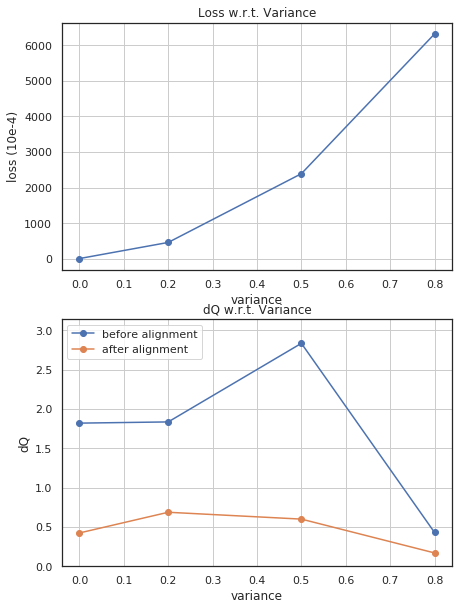

In [3]:
# losses
variances = [0.0, 0.2, 0.5, 0.8]
losses = np.array([3.55e-4, 4.57e-2, 2.39e-01, 6.32e-1])
scale_degree = 4
losses = losses * 10**scale_degree

# d_Q before alignment
d_Q_before = np.array([1.8203, 1.8357, 2.835, 0.43])

# d_Q after alignment
d_Q_after = np.array([0.424, 0.687, 0.6, 0.17])


fig, ax = plt.subplots(2, 1, figsize=(7,10))
ax[0].plot(variances, losses, marker="o")
ax[0].set(xlabel='variance', ylabel=f'loss (10e{-scale_degree})', title='Loss w.r.t. Variance')
ax[0].grid()
ax[1].plot(variances, d_Q_before, marker="o", label='before alignment')
ax[1].set(xlabel='variance', ylabel='dQ', title='dQ w.r.t. Variance')
ax[1].plot(variances, d_Q_after, marker="o", label='after alignment')
ax[1].set_ylim((0, np.pi))
ax[1].grid()
ax[1].legend()

#fig.savefig("test.png")
plt.show()

---

### 1.2. Data Preparation

In [3]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [4]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


#### Projections

In [5]:
projections = data['Projections']

#### True Angles

In [6]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

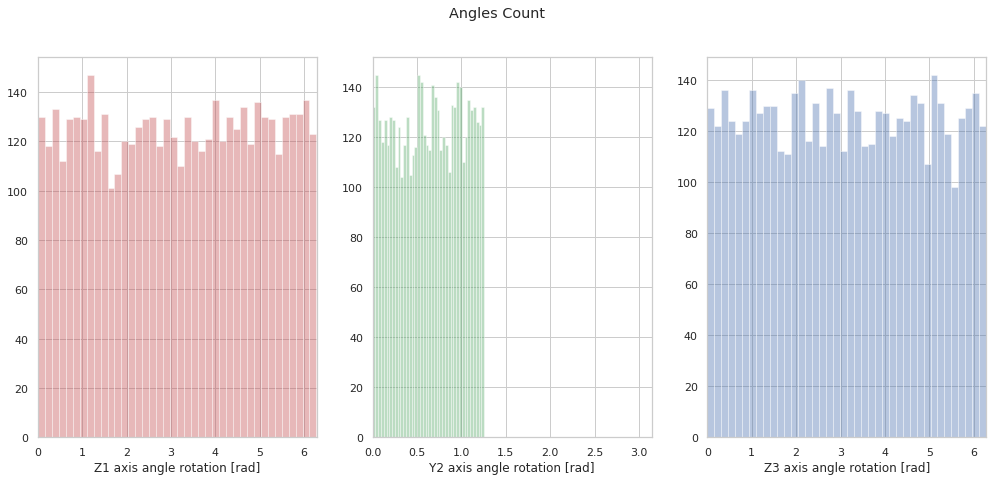

In [27]:
plot_angles_count(angles_true)

In [28]:
plot_rays(angles_true, indices=range(100))

In [ ]:
display(ipv.screenshot())

Output()

In [ ]:
plot_images(angles_true, projections, indices=range(100), img_size_scale=0.05)

In [9]:
display(ipv.screenshot())

Output()

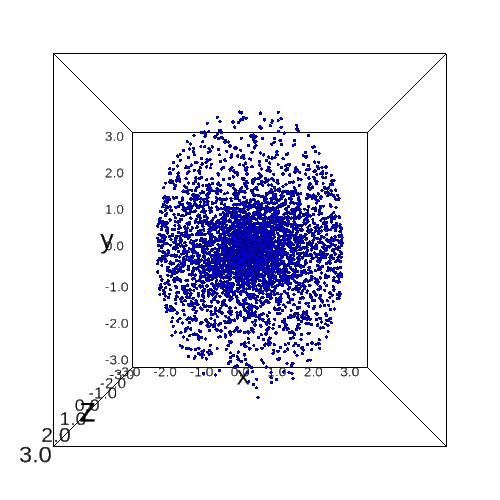

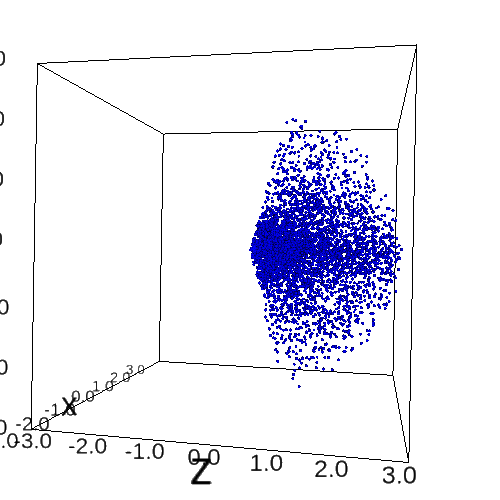

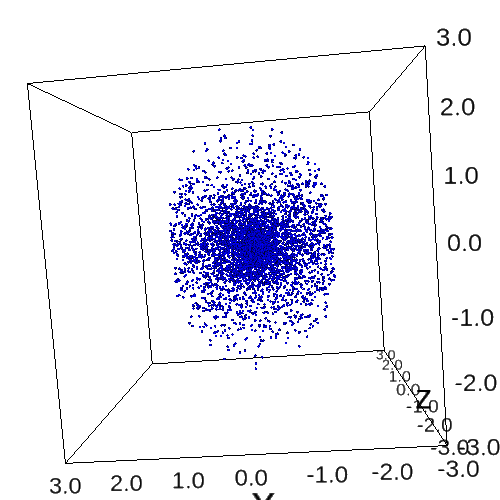

In [7]:
plot_angles_with_3rd_angle_magnitude(angles_true)

In [10]:
display(ipv.screenshot())

Output()

#### Predicted Angles

In [7]:
angle_shift = [0.0, 0.0, 0.0]
angle_coverage = [2.0, 0.4, 2.0]

In [8]:
low_ang = [x*np.pi for x in angle_shift]
high_ang = [x*np.pi for x in angle_coverage]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(angles_true), 3))

angles_predicted = [tf.Variable(e) for e in euler]


angles_predicted = np.array(angles_predicted)
angles_predicted.shape

(5000,)

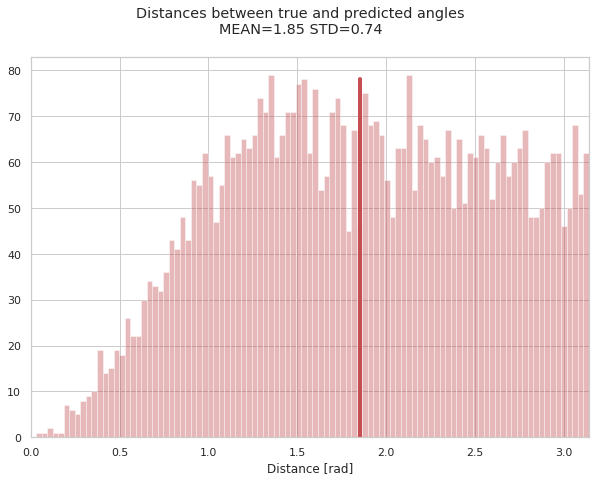

In [9]:
plot_distances_count(angles_predicted, angles_true)

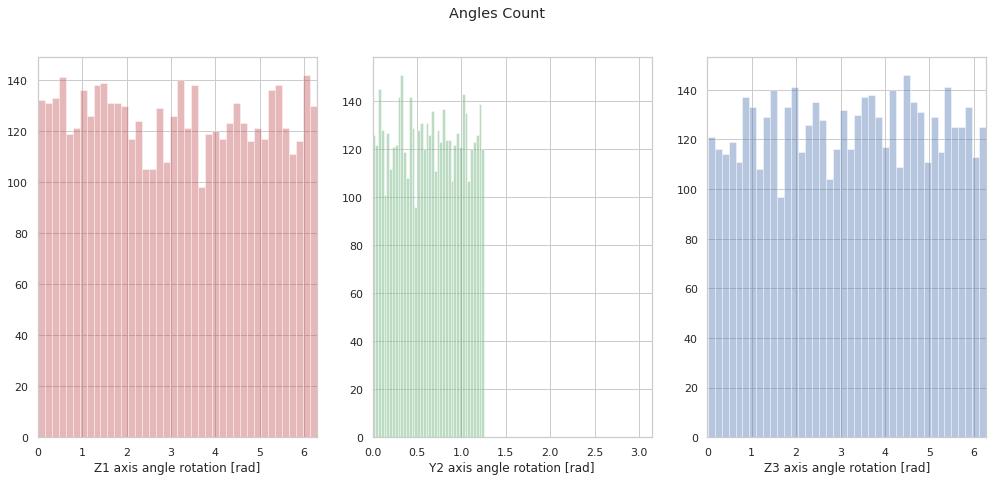

In [11]:
plot_angles_count(angles_predicted)

In [11]:
plot_euclidean_space(angles_predicted)

In [12]:
plot_euclidean_space(angles_true)

---

### 1.3. Angle Recovery: Perfect Distance

#### dP/dQ plot

In [12]:
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [13]:
def d_p(in1, in2):
    return d_q(in1, in2)

In [14]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

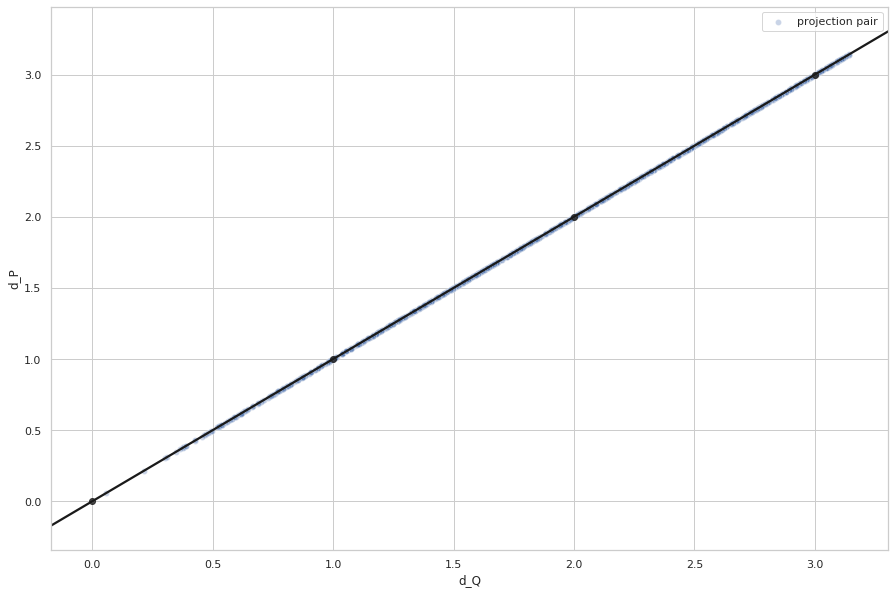

In [15]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

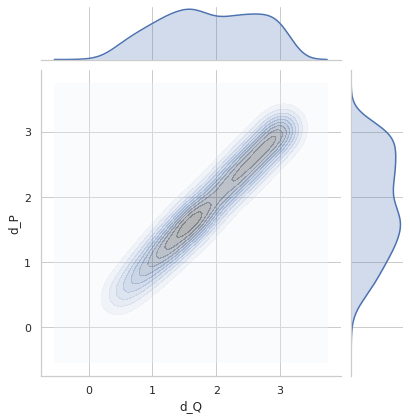

In [16]:
plot_dP_dQ_density(dP_values, dQ_values)

#### Angle Recovery

Perfect distances. Learning rate 0.01

In [17]:
from cryoem.angle_recovery import train_angle_recovery

step 15000/150000 (2425s): loss = 8.45e-02
	avg. distance difference: 1.86
step 30000/150000 (4757s): loss = 7.89e-02
	avg. distance difference: 1.87
step 45000/150000 (7250s): loss = 2.24e-02
	avg. distance difference: 1.86
step 60000/150000 (9689s): loss = 2.13e-03
	avg. distance difference: 1.87
step 75000/150000 (12149s): loss = 9.86e-04
	avg. distance difference: 1.87
step 90000/150000 (14599s): loss = 4.04e-04
	avg. distance difference: 1.87
step 105000/150000 (16990s): loss = 4.89e-04
	avg. distance difference: 1.87
step 120000/150000 (19396s): loss = 4.74e-04
	avg. distance difference: 1.87
step 135000/150000 (21853s): loss = 4.06e-04
	avg. distance difference: 1.87
step 150000/150000 (24372s): loss = 3.55e-04
	avg. distance difference: 1.87


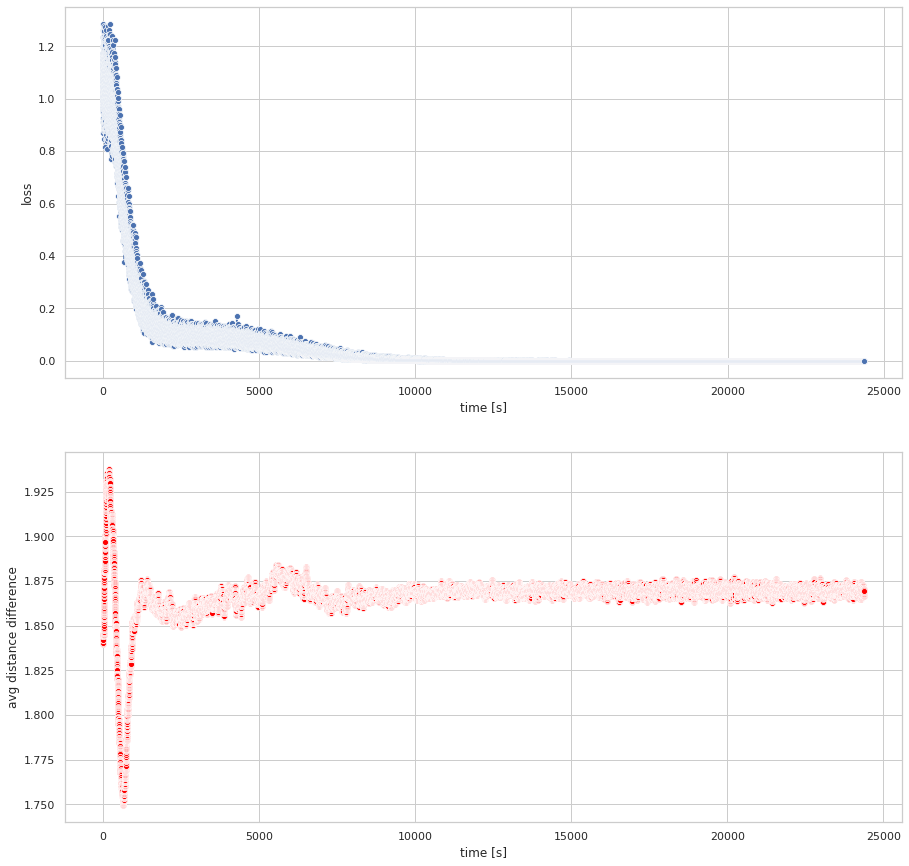

In [17]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [10]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles.npy")

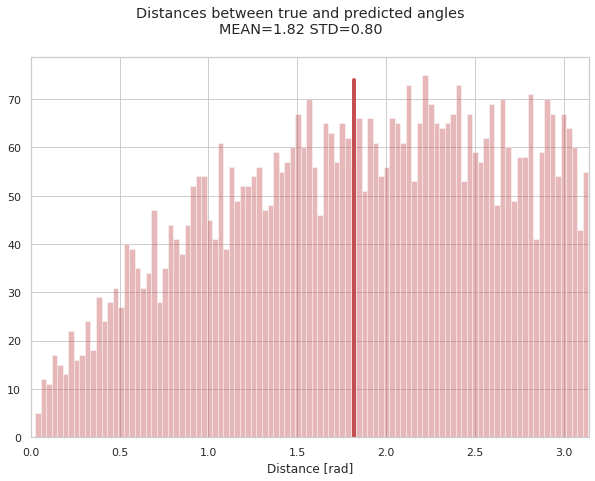

In [11]:
plot_distances_count(ap, angles_true)

In [9]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

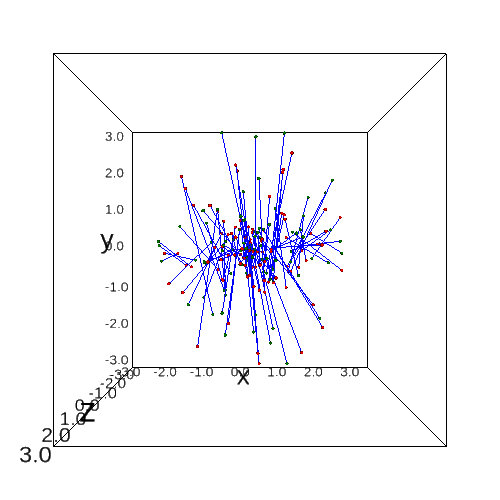

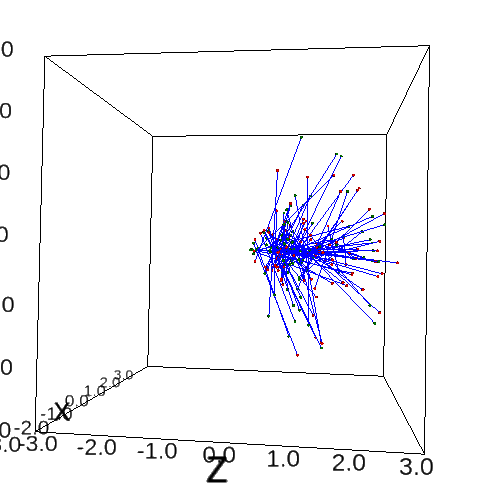

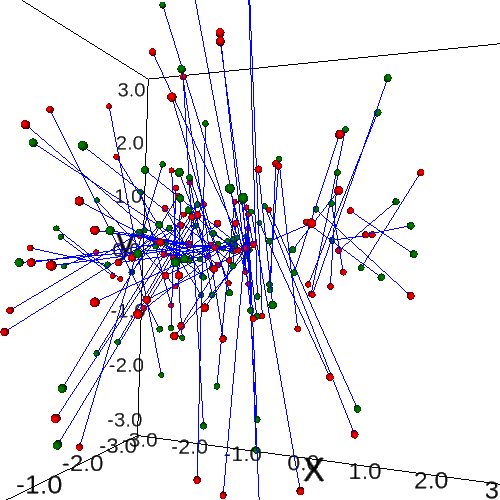

In [24]:
plot_selected_angles_with_3rd_angle_magnitude(ap, angles_true, range(100))

In [27]:
display(ipv.screenshot())

Output()

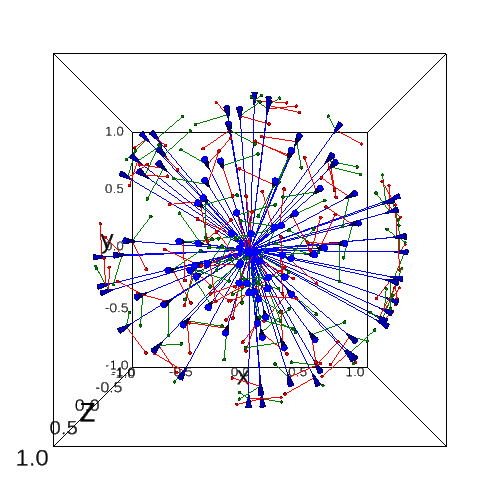

In [11]:
plot_rays(ap, indices=range(100))

In [12]:
display(ipv.screenshot())

Output()

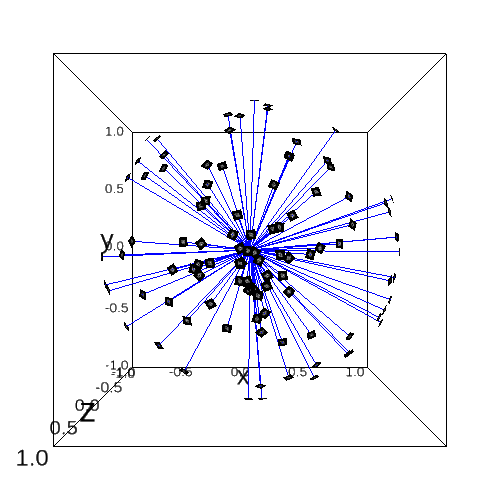

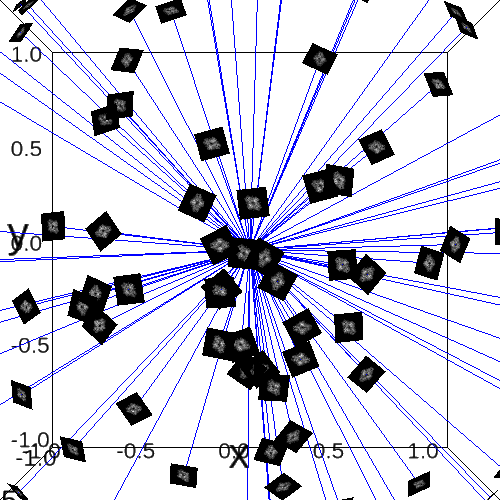

In [12]:
plot_images(ap, projections, indices=range(100),img_size_scale=0.05)

In [14]:
display(ipv.screenshot())

Output()

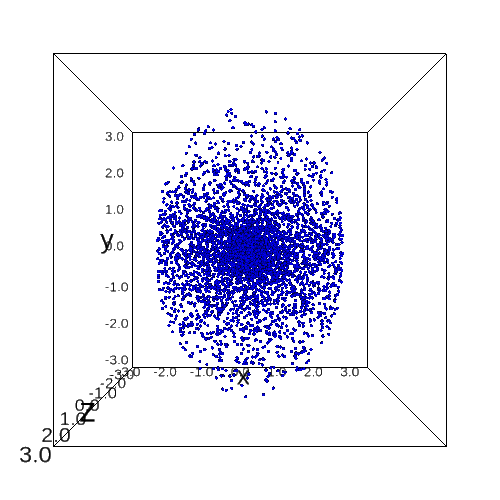

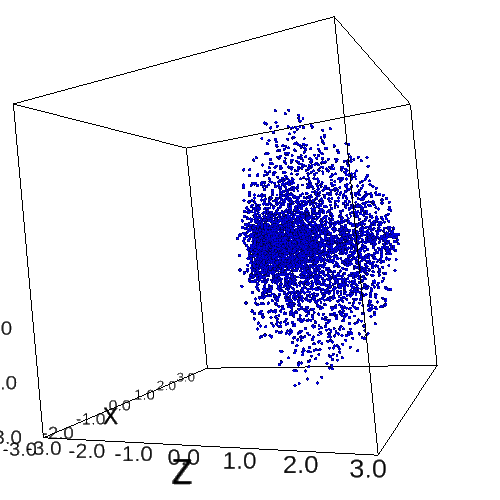

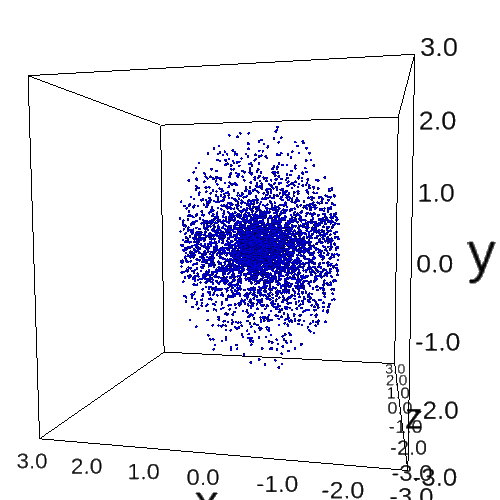

In [12]:
plot_angles_with_3rd_angle_magnitude(ap)

In [15]:
display(ipv.screenshot())

Output()

#### Angles' Alignment

In [20]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, updateR_alignment

#### Quaternion Alignment

In [21]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7032069418361836
Geodesic distance:  0.7604611064291664  rad ( 43.57121188224015  degrees)
Quaternion distance:  1.820303758799054


(0.7032069418361836, 0.7604611064291664, 1.820303758799054)

FLIPPING: (1, 1, 1)
step 100/1000 (9s): loss = 1.80e+00
step 200/1000 (18s): loss = 1.77e+00
step 300/1000 (29s): loss = 1.92e+00
step 400/1000 (40s): loss = 1.75e+00
step 500/1000 (49s): loss = 1.80e+00
step 600/1000 (59s): loss = 1.81e+00
step 700/1000 (68s): loss = 1.81e+00
step 800/1000 (78s): loss = 1.76e+00
step 900/1000 (86s): loss = 1.77e+00
step 1000/1000 (96s): loss = 1.78e+00
Rotation: [ 0.80739464 -0.00471915  0.81876827];  Loss: 1.7839028725142063
FLIPPING: (1, 1, -1)
step 100/1000 (10s): loss = 1.51e+00
step 200/1000 (19s): loss = 1.60e+00
step 300/1000 (27s): loss = 1.46e+00
step 400/1000 (36s): loss = 1.54e+00
step 500/1000 (46s): loss = 1.58e+00
step 600/1000 (56s): loss = 1.52e+00
step 700/1000 (66s): loss = 1.53e+00
step 800/1000 (77s): loss = 1.55e+00
step 900/1000 (89s): loss = 1.53e+00
step 1000/1000 (100s): loss = 1.53e+00
Rotation: [-0.03812183  0.02918632 -0.12780915];  Loss: 1.5307099309571985
FLIPPING: (1, -1, 1)
step 100/1000 (9s): loss = 1.87e+00
step 200/1

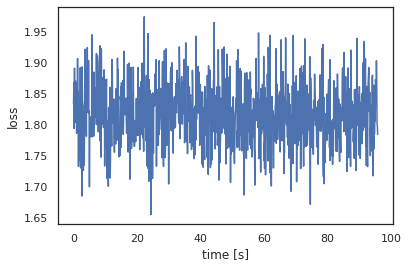

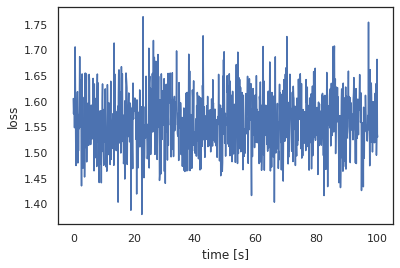

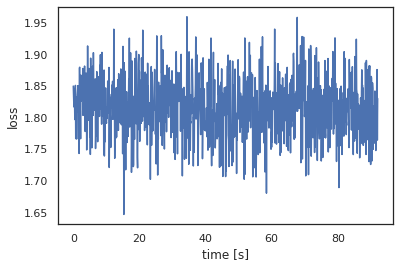

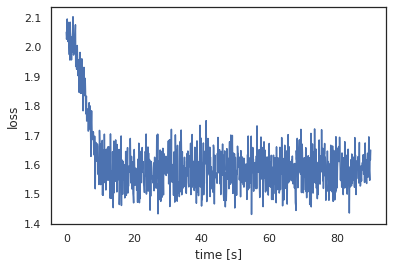

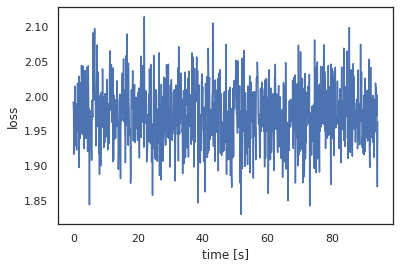

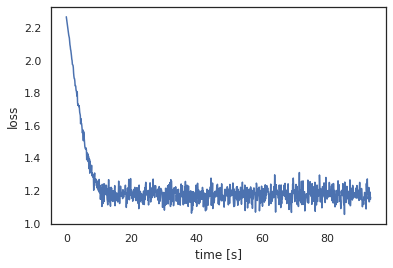

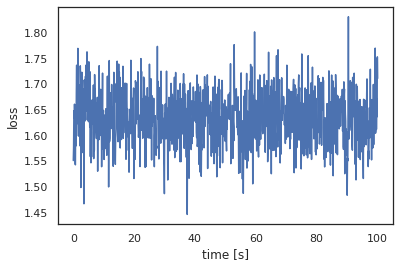

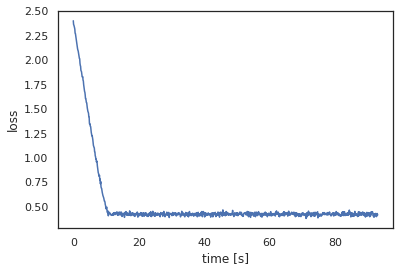

In [22]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=5000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [23]:
flips, a_R, loss

((-1, -1, -1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([ 1.14849679, -0.02104091,  1.14812488])>],
 0.42213148365861924)

In [24]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [25]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.3483273461284011
Geodesic distance:  0.3514384553197312  rad ( 20.135940248417555  degrees)
Quaternion distance:  0.42381747222864086


(0.3483273461284011, 0.3514384553197312, 0.42381747222864086)

In [26]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [15]:
display(ipv.screenshot())

Output()

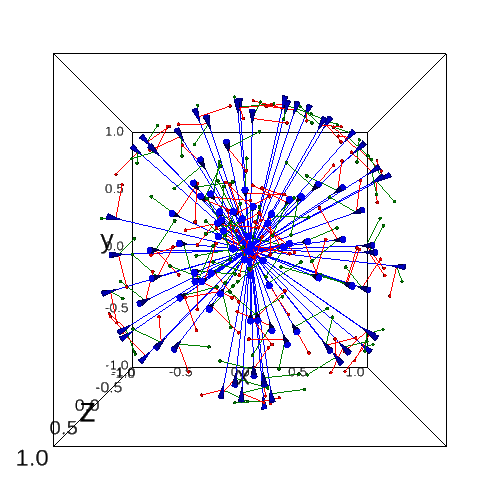

In [16]:
plot_rays(angles_predicted_new, range(100))

In [17]:
display(ipv.screenshot())

Output()

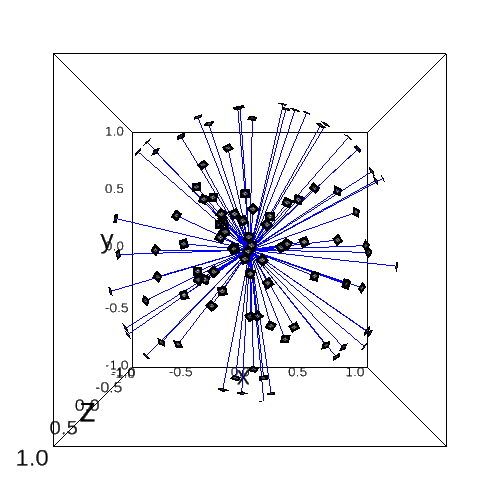

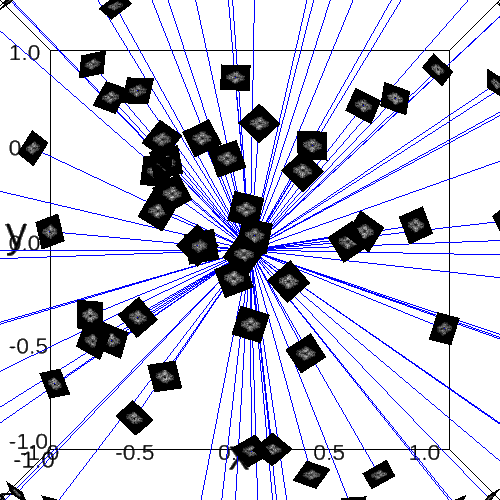

In [18]:
plot_images(angles_predicted_new, projections, indices=range(100),img_size_scale=0.05)

In [20]:
display(ipv.screenshot())

Output()

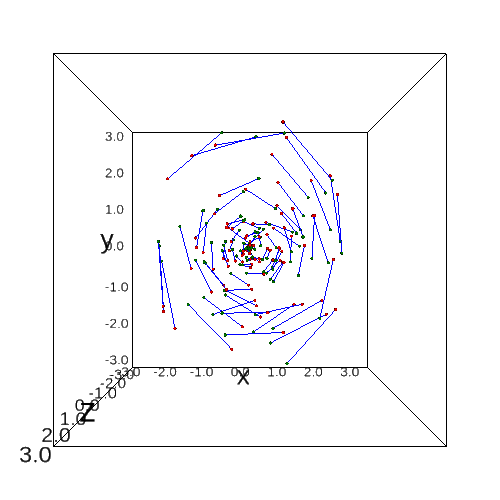

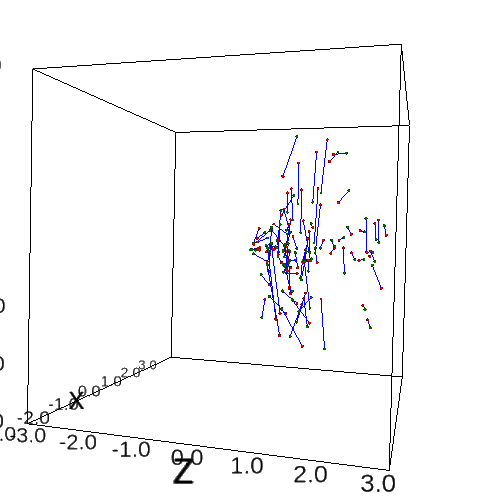

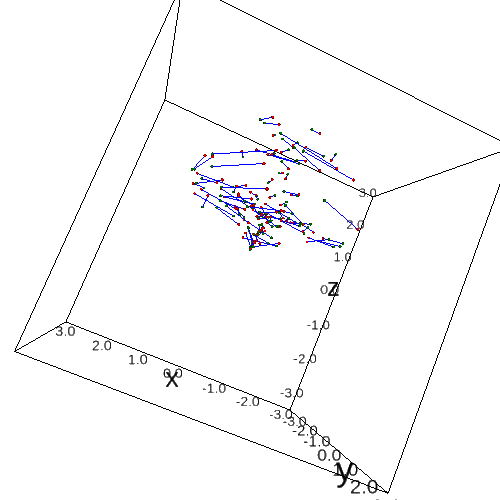

In [29]:
plot_selected_angles_with_3rd_angle_magnitude(angles_predicted_new, angles_true, range(100))

In [32]:
display(ipv.screenshot())

Output()

---

### 1.4. Angle Recovery: Variance 0.0

#### dP/dQ plot

In [12]:
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [13]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.0, dtype=tf.float64)
    return norm_distr  

In [14]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)#.T[0]
dQ_values = d_q(q1_true, q2_true)#.numpy()

<Figure size 432x288 with 0 Axes>

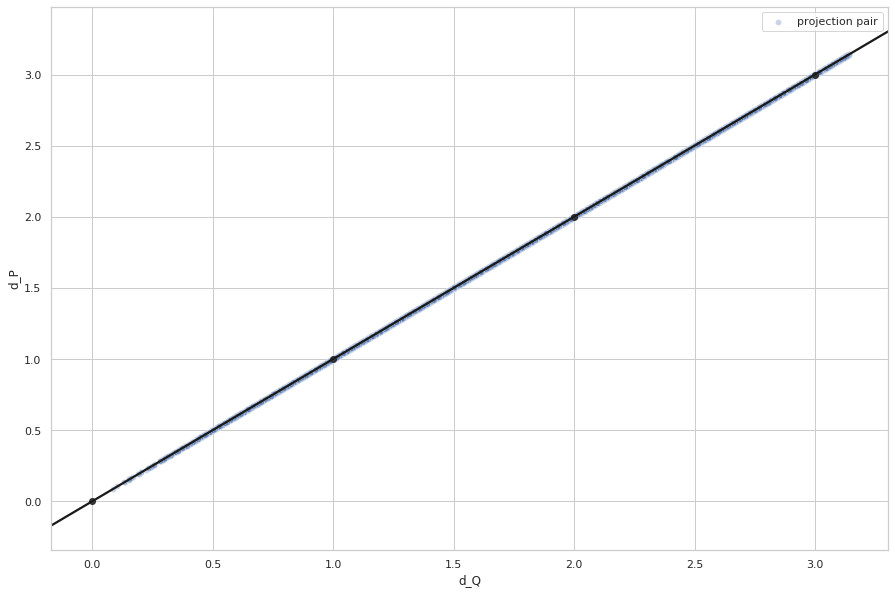

In [15]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

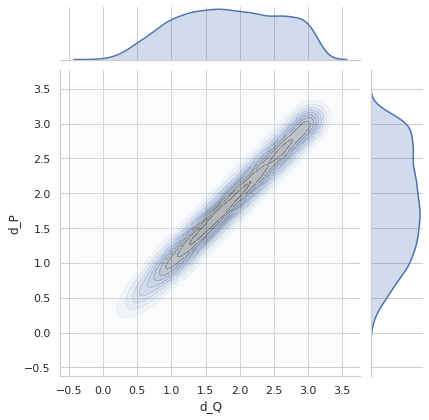

In [16]:
plot_dP_dQ_density(dP_values, dQ_values)

## Angle Recovery

Perfect distances. Learning rate 0.01

In [17]:
from cryoem.angle_recovery import train_angle_recovery

step 15000/150000 (1500s): loss = 6.61e-02
step 30000/150000 (3059s): loss = 9.10e-02
step 45000/150000 (4635s): loss = 3.19e-02
step 60000/150000 (6222s): loss = 2.89e-03
step 75000/150000 (7805s): loss = 5.46e-04
step 90000/150000 (9334s): loss = 3.15e-04
step 105000/150000 (10806s): loss = 3.83e-04
step 120000/150000 (12269s): loss = 4.17e-04
step 135000/150000 (13768s): loss = 4.43e-04
step 150000/150000 (15280s): loss = 4.63e-04


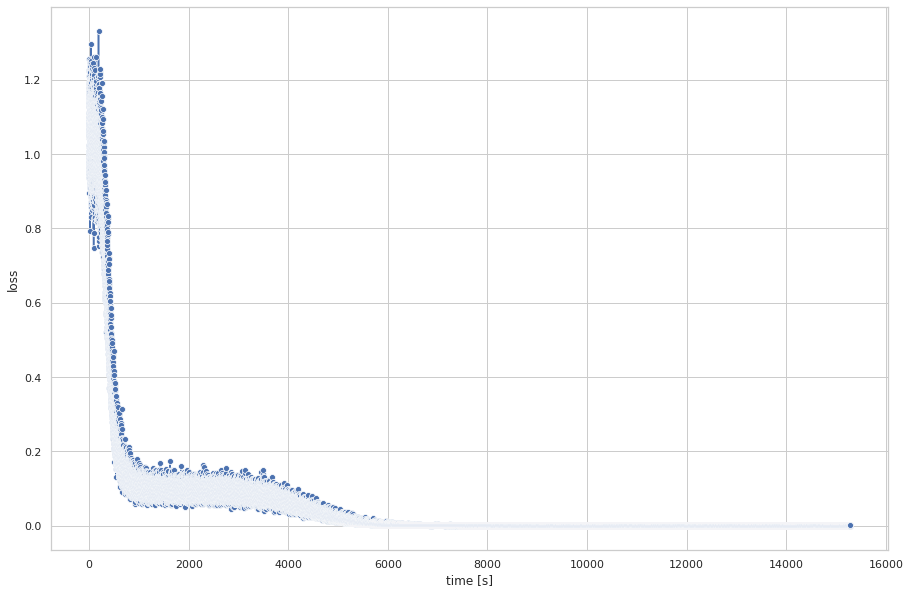

In [18]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [19]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/predicted_angles_var0.npy", ang_save)

In [12]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles_var0.npy")

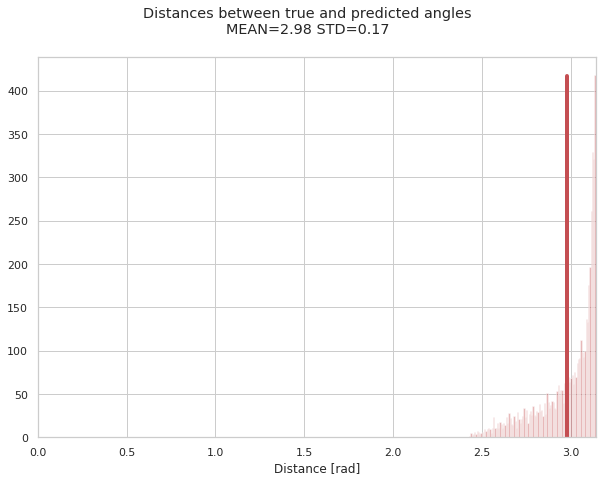

In [13]:
plot_distances_count(ap, angles_true)

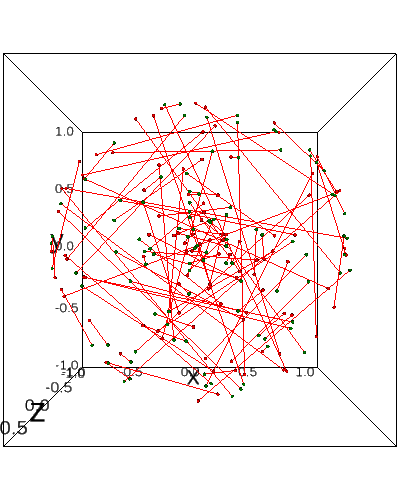

In [21]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [22]:
filename = f"figures/{PROTEIN}_before_alignment_var0"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

### Angle Alignment

In [23]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, training_angle_alignment_GD_flips, updateR_alignment, updateGD_alignment

#### Quaternion Alignment

In [24]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7045834962517638
Geodesic distance:  0.7627110548478984  rad ( 43.70012443075562  degrees)
Quaternion distance:  2.9827042917375386


(0.7045834962517638, 0.7627110548478984, 2.9827042917375386)

FLIPPING: (1, 1, 1)
step 500/5000 (33s): loss = 8.50e-01
step 1000/5000 (66s): loss = 7.88e-01
step 1500/5000 (98s): loss = 8.54e-01
step 2000/5000 (131s): loss = 8.45e-01
step 2500/5000 (164s): loss = 8.05e-01
step 3000/5000 (197s): loss = 7.59e-01
step 3500/5000 (231s): loss = 8.31e-01
step 4000/5000 (265s): loss = 7.75e-01
step 4500/5000 (299s): loss = 8.31e-01
step 5000/5000 (333s): loss = 7.99e-01
Rotation: [1.65955685 0.02784008 1.47349226];  Loss: 0.7986765517607015
FLIPPING: (1, 1, -1)
step 500/5000 (34s): loss = 1.88e+00
step 1000/5000 (69s): loss = 1.79e+00
step 1500/5000 (103s): loss = 1.94e+00
step 2000/5000 (137s): loss = 1.72e+00
step 2500/5000 (173s): loss = 1.86e+00
step 3000/5000 (208s): loss = 1.73e+00
step 3500/5000 (243s): loss = 1.85e+00
step 4000/5000 (278s): loss = 1.91e+00
step 4500/5000 (313s): loss = 1.73e+00
step 5000/5000 (348s): loss = 1.80e+00
Rotation: [0.56528137 0.01908577 0.73672648];  Loss: 1.8042427620334487
FLIPPING: (1, -1, 1)
step 500/5000 (36s): 

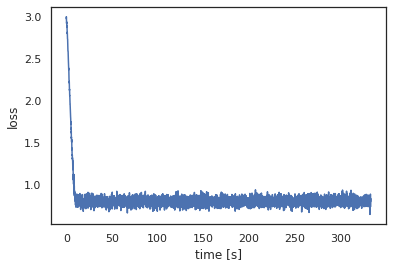

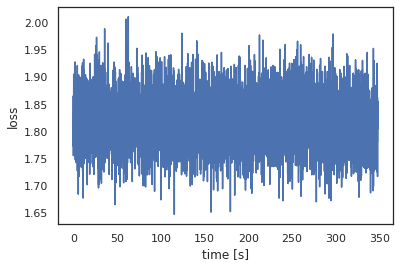

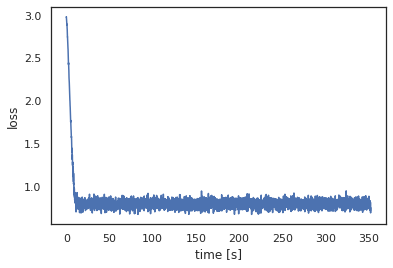

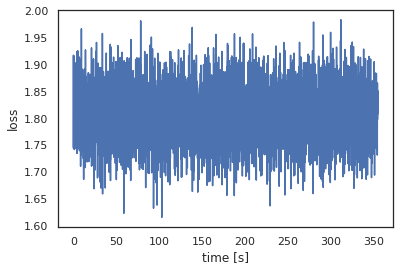

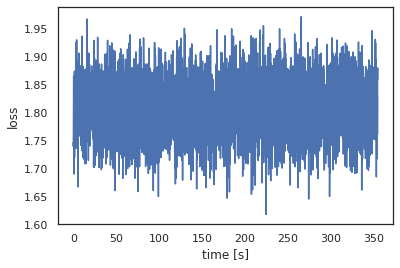

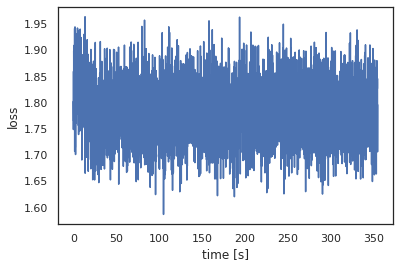

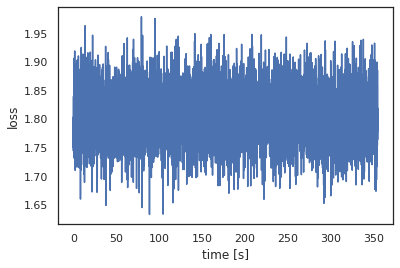

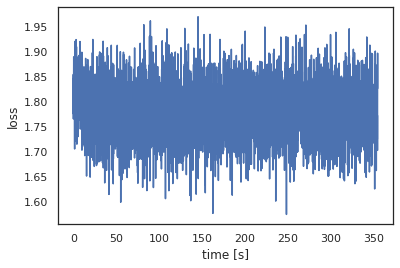

In [25]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=5000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [26]:
flips, a_R, loss

((1, 1, 1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([1.65955685, 0.02784008, 1.47349226])>],
 0.7986765517607015)

In [27]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [28]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.708708475641252
Geodesic distance:  0.7693563502287543  rad ( 44.08087180969645  degrees)
Quaternion distance:  0.8017133483967951


(0.708708475641252, 0.7693563502287543, 0.8017133483967951)

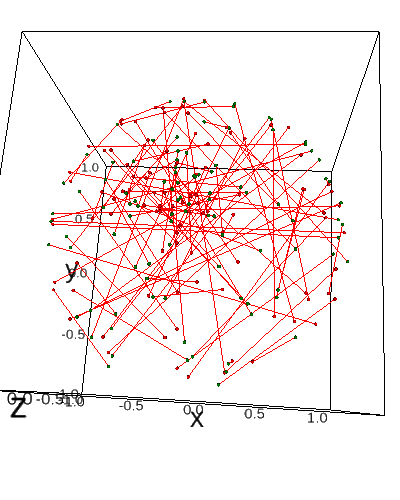

In [29]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [30]:
filename = f"figures/{PROTEIN}_after_alignment_var0"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

---

### 1.5. Angle Recovery: Variance 0.2

#### dP/dQ plot

In [9]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.2, dtype=tf.float64)
    return norm_distr  

In [10]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

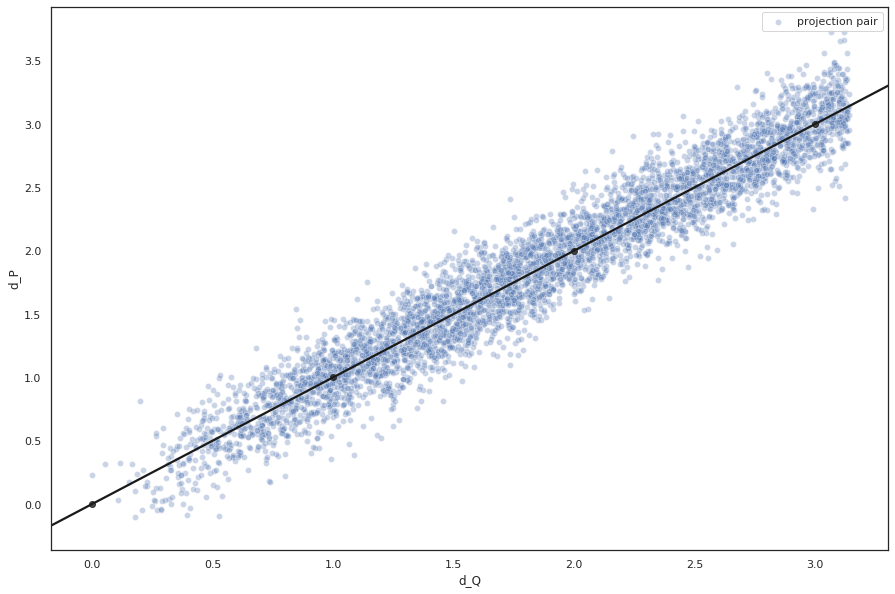

In [11]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

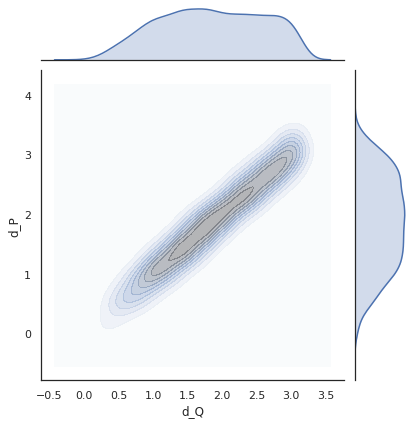

In [12]:
plot_dP_dQ_density(dP_values, dQ_values)

In [13]:
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.19981824166655646

#### Angle Recovery

In [11]:
# Try smaller variance until it is possible to converge

step 15000/150000 (1497s): loss = 1.57e-01
step 30000/150000 (2984s): loss = 1.17e-01
step 45000/150000 (4472s): loss = 9.68e-02
step 60000/150000 (5983s): loss = 7.67e-02
step 75000/150000 (7498s): loss = 5.80e-02
step 90000/150000 (9019s): loss = 4.75e-02
step 105000/150000 (10539s): loss = 4.10e-02
step 120000/150000 (12061s): loss = 4.31e-02
step 135000/150000 (13583s): loss = 4.48e-02
step 150000/150000 (15108s): loss = 4.57e-02


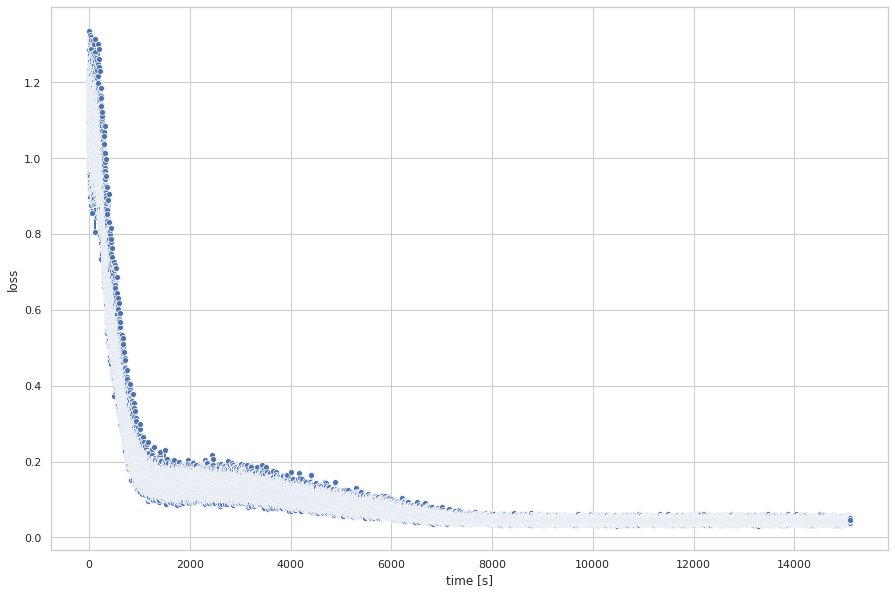

In [16]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [17]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/predicted_angles_var0.2.npy", ang_save)

In [14]:
ap = np.load("data/predicted_angles_var0.2.npy")

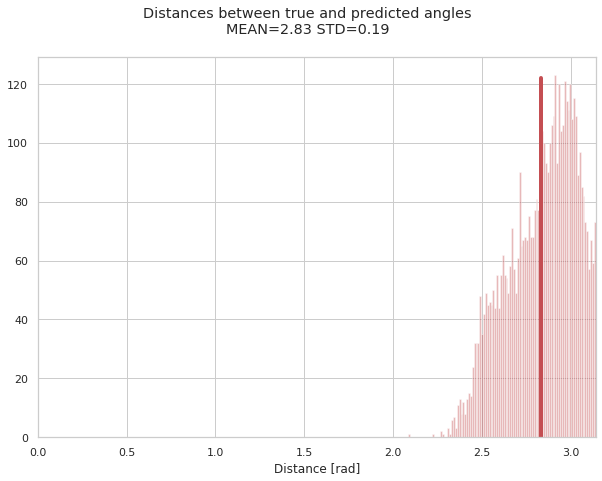

In [15]:
plot_distances_count(ap, angles_true)

In [12]:
plot_euclidean_space(ap)

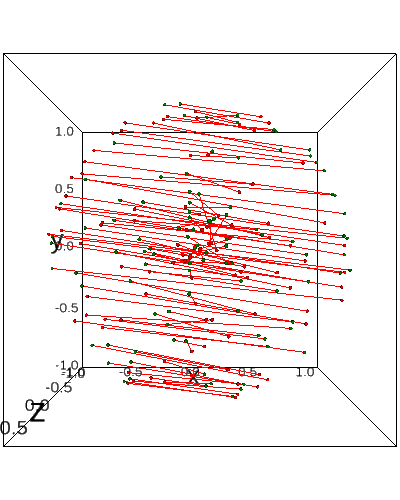

In [12]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [13]:
filename = f"figures/{PROTEIN}_before_alignment_var0.2"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

#### Angles' Alignment

In [12]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, training_angle_alignment_GD_flips, updateR_alignment, updateGD_alignment

#### Quaternion Alignment

In [16]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7171640657905557
Geodesic distance:  0.777618468080542  rad ( 44.55425629244358  degrees)
Quaternion distance:  1.835719976707717


(0.7171640657905557, 0.777618468080542, 1.835719976707717)

FLIPPING: (1, 1, 1)
step 100/1000 (7s): loss = 1.83e+00
step 200/1000 (14s): loss = 1.76e+00
step 300/1000 (21s): loss = 1.78e+00
step 400/1000 (28s): loss = 1.82e+00
step 500/1000 (36s): loss = 1.84e+00
step 600/1000 (43s): loss = 1.78e+00
step 700/1000 (51s): loss = 1.87e+00
step 800/1000 (58s): loss = 1.82e+00
step 900/1000 (65s): loss = 1.86e+00
step 1000/1000 (72s): loss = 1.78e+00
Rotation: [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([1.41988991, 0.03042958, 1.41505037])>];  Loss: 1.7774665455065515
FLIPPING: (1, 1, -1)
step 100/1000 (7s): loss = 1.62e+00
step 200/1000 (15s): loss = 1.60e+00
step 300/1000 (22s): loss = 1.46e+00
step 400/1000 (29s): loss = 1.63e+00
step 500/1000 (36s): loss = 1.54e+00
step 600/1000 (43s): loss = 1.57e+00
step 700/1000 (50s): loss = 1.54e+00
step 800/1000 (57s): loss = 1.54e+00
step 900/1000 (64s): loss = 1.53e+00
step 1000/1000 (71s): loss = 1.50e+00
Rotation: [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([-

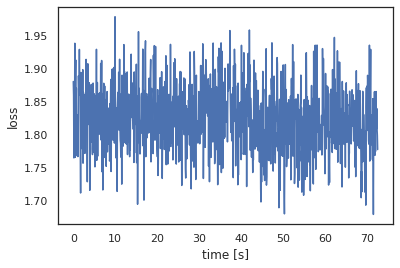

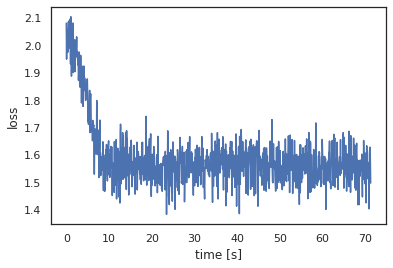

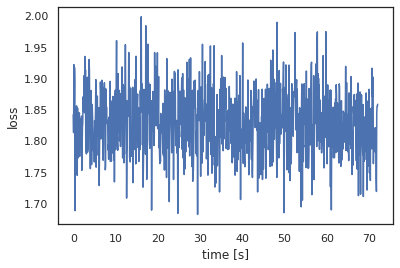

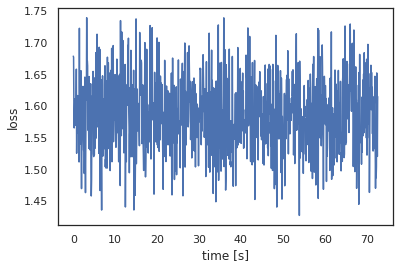

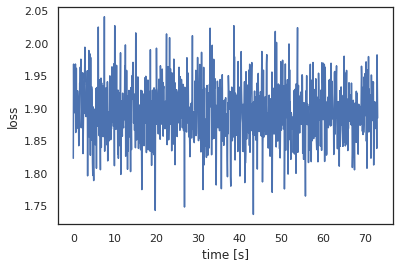

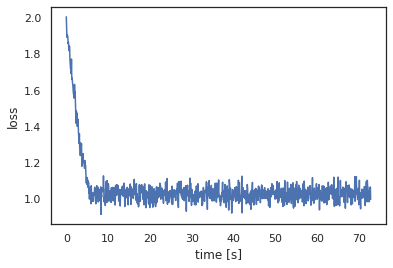

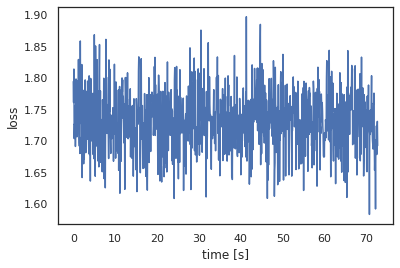

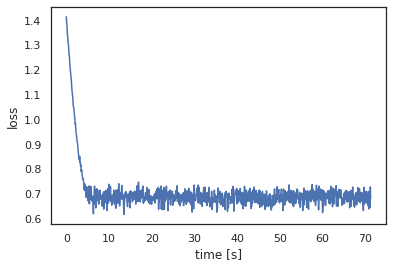

In [19]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [20]:
flips, a_R, loss

((-1, -1, -1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([0.6723221 , 0.00503317, 0.66916668])>],
 0.6810453277207049)

In [21]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [22]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.5681775972717877
Geodesic distance:  0.5824413158483789  rad ( 33.371429212158255  degrees)
Quaternion distance:  0.6866994489334189


(0.5681775972717877, 0.5824413158483789, 0.6866994489334189)

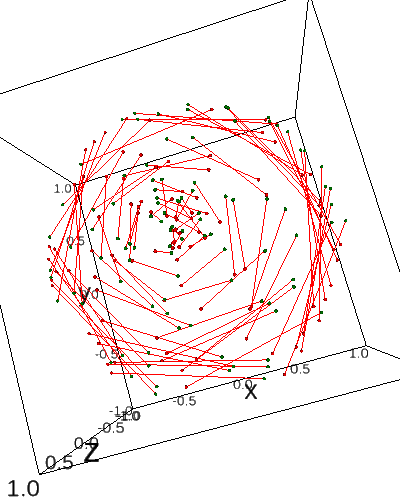

In [23]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [24]:
filename = f"figures/{PROTEIN}_after_alignment_var0.2"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

---

### 1.6. Angle Recovery: Variance 0.5

#### dP/dQ plot

In [8]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.5, dtype=tf.float64)
    return norm_distr  

In [9]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

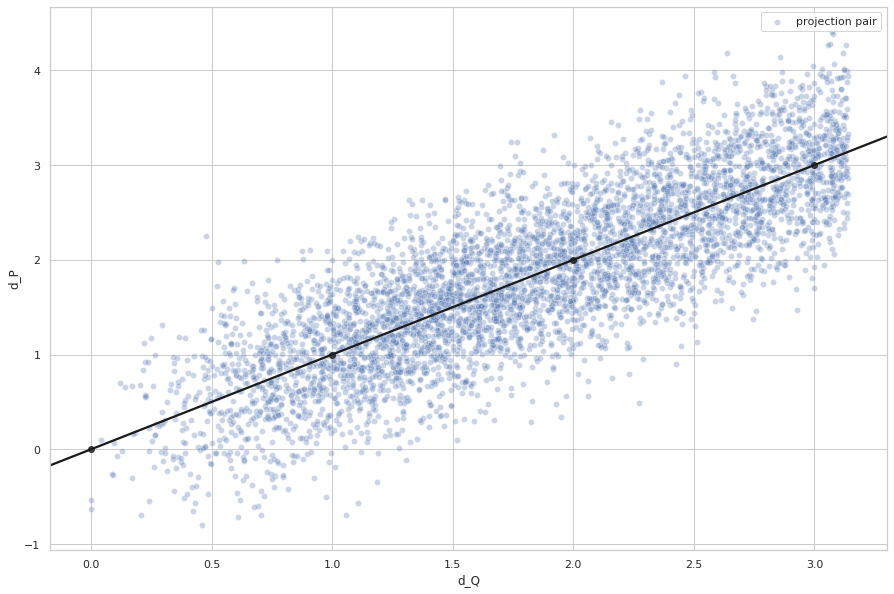

In [10]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

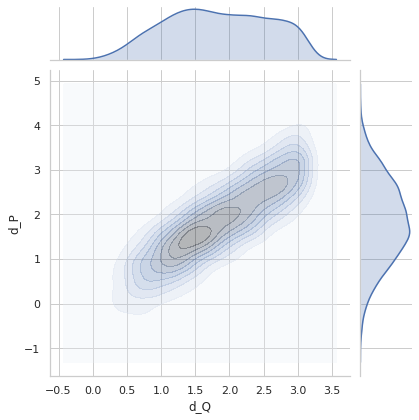

In [11]:
plot_dP_dQ_density(dP_values, dQ_values)

#### Angle Recovery

In [17]:
# Try smaller variance until it is possible to converge

step 15000/150000 (1479s): loss = 3.88e-01
step 30000/150000 (3094s): loss = 3.71e-01
step 45000/150000 (4536s): loss = 3.34e-01
step 60000/150000 (5967s): loss = 2.80e-01
step 75000/150000 (7404s): loss = 2.69e-01
step 90000/150000 (8849s): loss = 2.97e-01
step 105000/150000 (10289s): loss = 2.46e-01
step 120000/150000 (11728s): loss = 2.36e-01
step 135000/150000 (13160s): loss = 2.97e-01
step 150000/150000 (14594s): loss = 2.39e-01


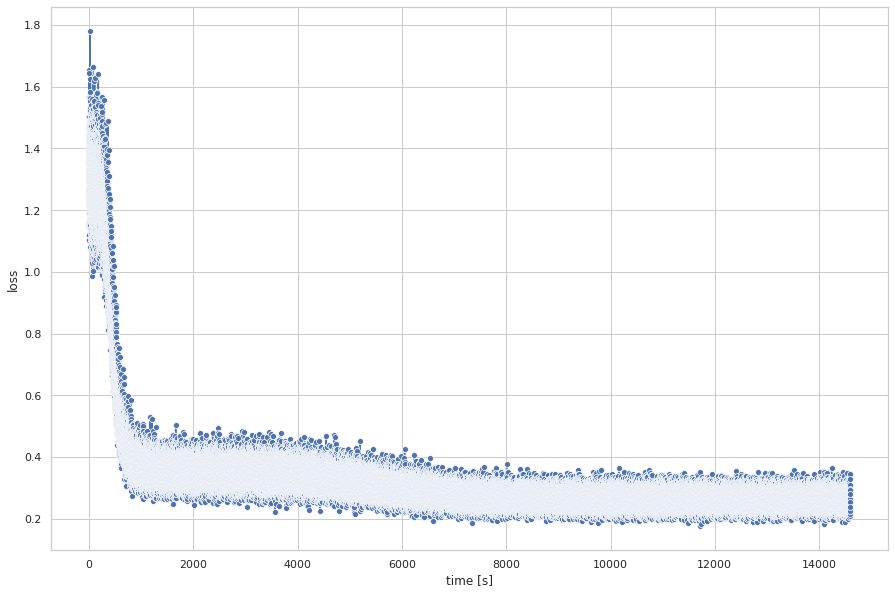

In [18]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [20]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/predicted_angles_var0.5.npy", ang_save)

In [16]:
ap = np.load("data/predicted_angles_var0.5.npy")

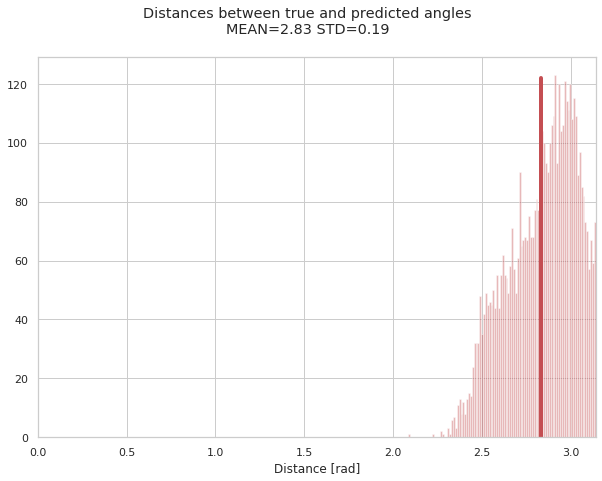

In [17]:
plot_distances_count(ap, angles_true)

In [13]:
plot_euclidean_space(ap)

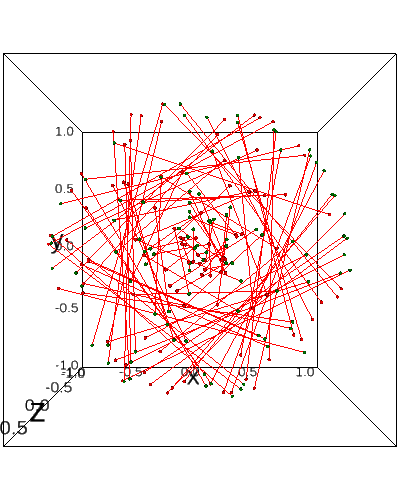

In [14]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [15]:
filename = f"figures/{PROTEIN}_before_alignment_var0.5"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

#### Angle Alignment

In [16]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, training_angle_alignment_GD_flips, updateR_alignment, updateGD_alignment

In [26]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.9324589901125475
Geodesic distance:  1.0115875841705928  rad ( 57.95969918080989  degrees)
Quaternion distance:  2.8346353468529544


(0.9324589901125475, 1.0115875841705928, 2.8346353468529544)

FLIPPING: (1, 1, 1)
step 100/1000 (7s): loss = 1.10e+00
step 200/1000 (13s): loss = 6.23e-01
step 300/1000 (20s): loss = 5.99e-01
step 400/1000 (26s): loss = 6.31e-01
step 500/1000 (33s): loss = 5.99e-01
step 600/1000 (39s): loss = 5.97e-01
step 700/1000 (46s): loss = 6.05e-01
step 800/1000 (52s): loss = 5.95e-01
step 900/1000 (59s): loss = 6.00e-01
step 1000/1000 (65s): loss = 6.08e-01
Rotation: [-1.43934947 -0.03795139 -1.47715881];  Loss: 0.6081999051700688
FLIPPING: (1, 1, -1)
step 100/1000 (7s): loss = 1.66e+00
step 200/1000 (13s): loss = 1.69e+00
step 300/1000 (20s): loss = 1.71e+00
step 400/1000 (26s): loss = 1.74e+00
step 500/1000 (33s): loss = 1.71e+00
step 600/1000 (39s): loss = 1.76e+00
step 700/1000 (46s): loss = 1.76e+00
step 800/1000 (52s): loss = 1.70e+00
step 900/1000 (59s): loss = 1.73e+00
step 1000/1000 (65s): loss = 1.71e+00
Rotation: [-0.89660289  0.05199161 -0.7643695 ];  Loss: 1.7119067920224431
FLIPPING: (1, -1, 1)
step 100/1000 (6s): loss = 1.53e+00
step 200/100

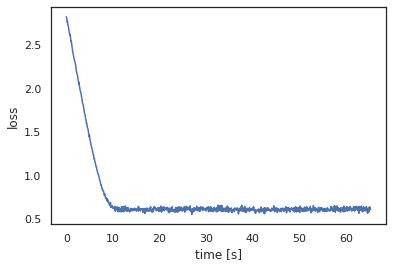

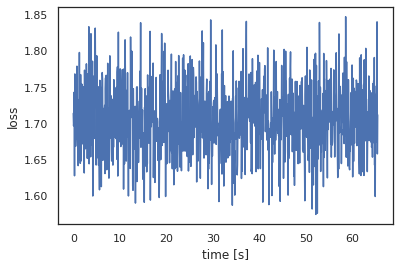

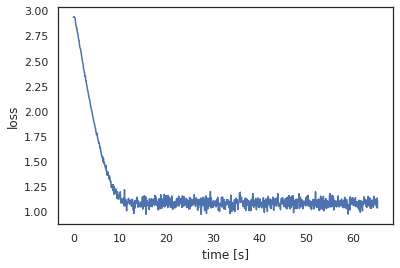

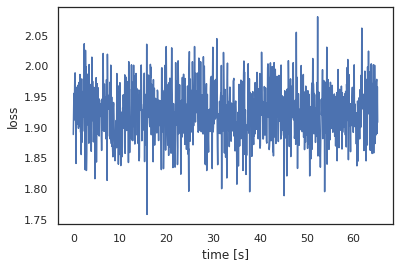

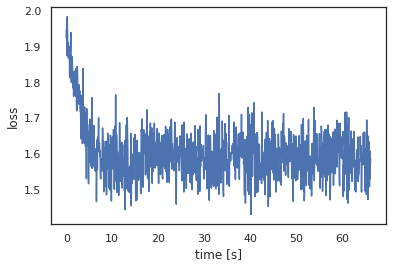

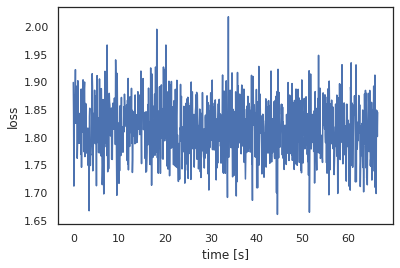

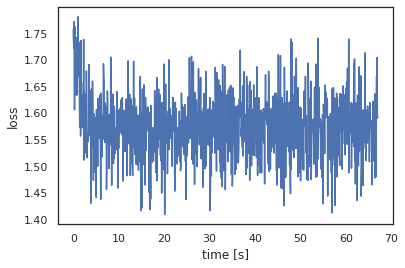

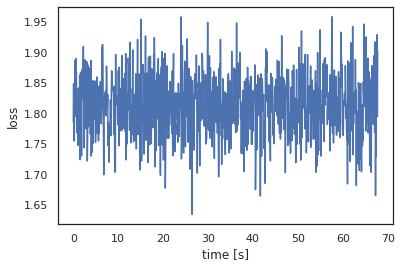

In [27]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [28]:
flips, a_R, loss

((1, 1, 1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([-1.43934947, -0.03795139, -1.47715881])>],
 0.6081999051700688)

In [29]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [30]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.49183101320633604
Geodesic distance:  0.5007041511794403  rad ( 28.688234647262252  degrees)
Quaternion distance:  0.6052543139518002


(0.49183101320633604, 0.5007041511794403, 0.6052543139518002)

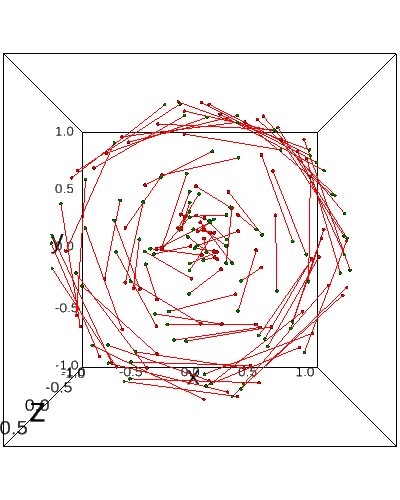

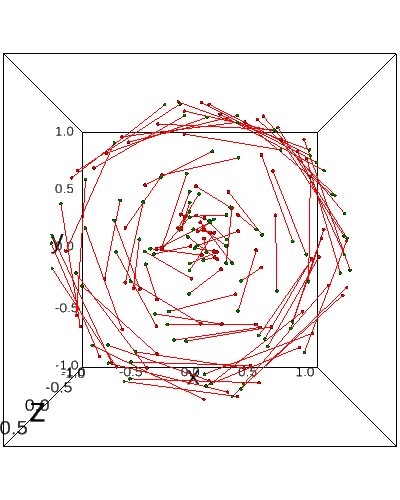

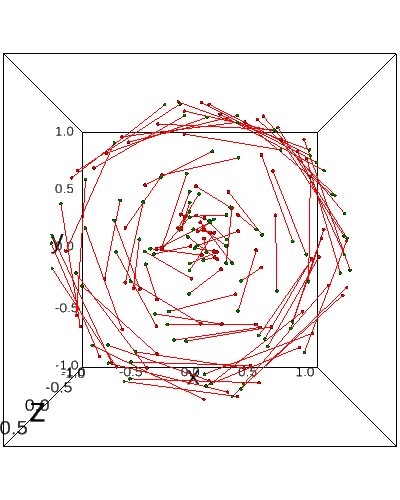

In [31]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [34]:
filename = f"figures/{PROTEIN}_after_alignment_var0.5"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

---

### 1.7. Angle Recovery: Variance 0.8

#### dP/dQ plot

In [13]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.8, dtype=tf.float64)
    return norm_distr  

In [14]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

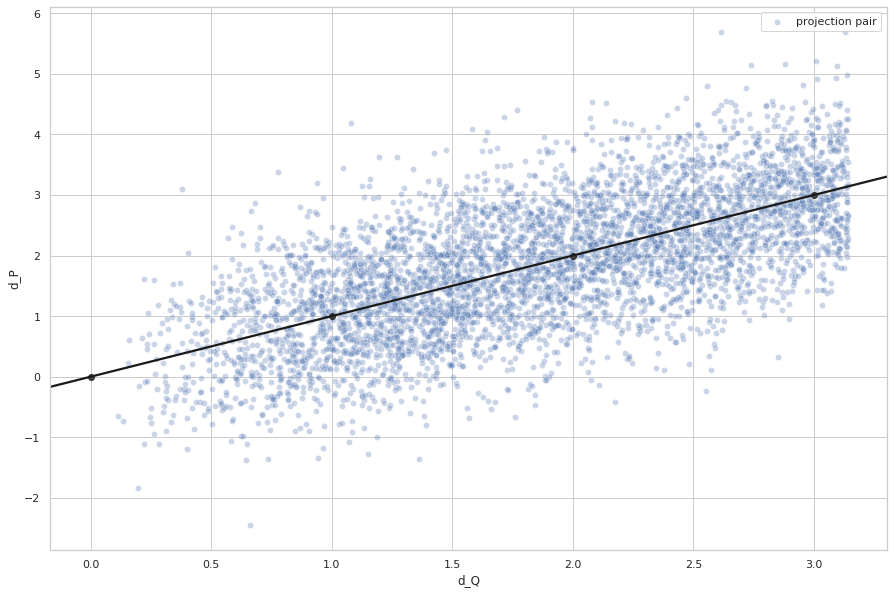

In [15]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

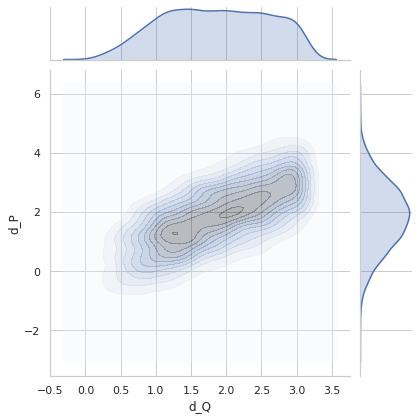

In [16]:
plot_dP_dQ_density(dP_values, dQ_values)

#### Angle Recovery

In [17]:
# Try smaller variance until it is possible to converge

step 15000/150000 (1377s): loss = 7.84e-01
step 30000/150000 (2800s): loss = 6.97e-01
step 45000/150000 (4231s): loss = 6.67e-01
step 60000/150000 (5712s): loss = 6.87e-01
step 75000/150000 (7162s): loss = 7.59e-01
step 90000/150000 (8665s): loss = 6.65e-01
step 105000/150000 (10180s): loss = 7.26e-01
step 120000/150000 (11723s): loss = 6.59e-01
step 135000/150000 (13170s): loss = 7.20e-01
step 150000/150000 (14638s): loss = 6.32e-01


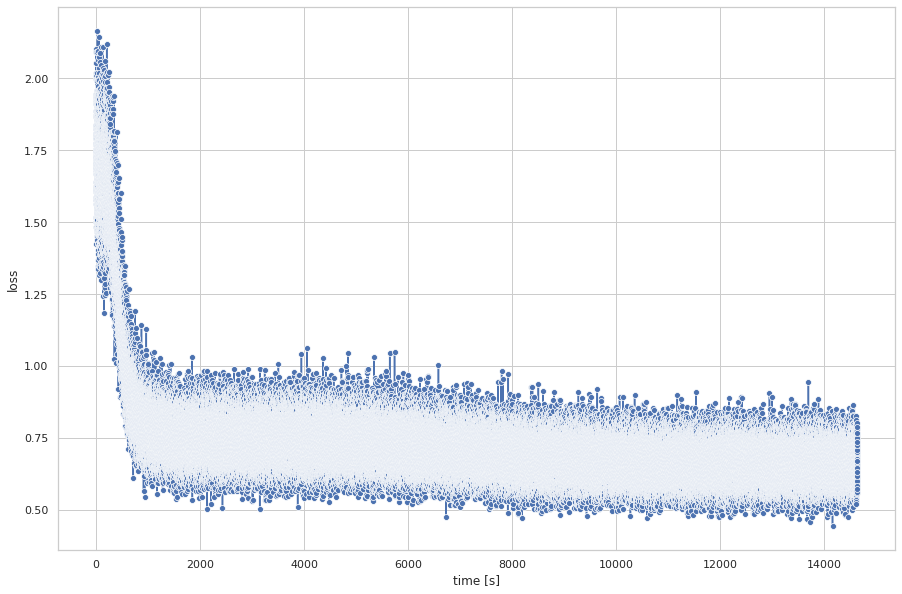

In [18]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [23]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/predicted_angles_var0.8.npy", ang_save)

In [18]:
ap = np.load("data/predicted_angles_var0.8.npy")

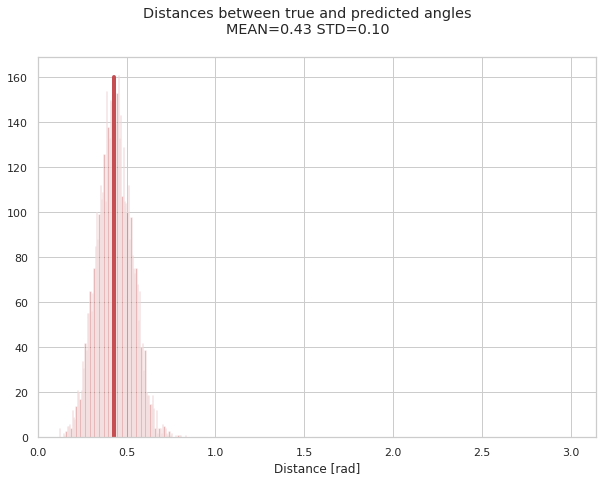

In [19]:
plot_distances_count(ap, angles_true)

In [25]:
plot_euclidean_space(ap)

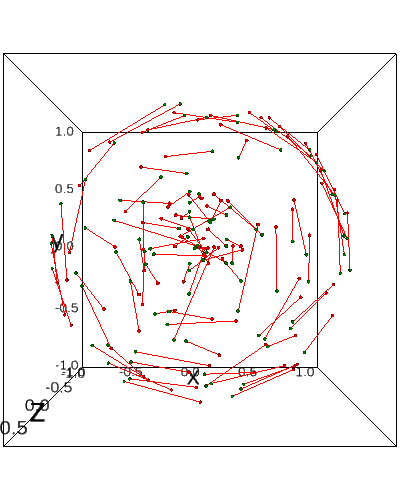

In [26]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [27]:
filename = f"figures/{PROTEIN}_before_alignment_var0.8"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

#### Angle Alignment

In [28]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, training_angle_alignment_GD_flips, updateR_alignment, updateGD_alignment

In [29]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.29311857540805325
Geodesic distance:  0.29482953242402793  rad ( 16.89248788371226  degrees)
Quaternion distance:  0.4303240739610892


(0.29311857540805325, 0.29482953242402793, 0.4303240739610892)

FLIPPING: (1, 1, 1)
step 100/1000 (6s): loss = 1.65e-01
step 200/1000 (13s): loss = 1.66e-01
step 300/1000 (20s): loss = 1.76e-01
step 400/1000 (26s): loss = 1.72e-01
step 500/1000 (33s): loss = 1.68e-01
step 600/1000 (40s): loss = 1.68e-01
step 700/1000 (46s): loss = 1.65e-01
step 800/1000 (53s): loss = 1.68e-01
step 900/1000 (59s): loss = 1.76e-01
step 1000/1000 (66s): loss = 1.75e-01
Rotation: [0.17098438 0.01317988 0.22689199];  Loss: 0.17521755508496734
FLIPPING: (1, 1, -1)
step 100/1000 (7s): loss = 1.53e+00
step 200/1000 (13s): loss = 1.54e+00
step 300/1000 (20s): loss = 1.63e+00
step 400/1000 (27s): loss = 1.54e+00
step 500/1000 (34s): loss = 1.57e+00
step 600/1000 (40s): loss = 1.62e+00
step 700/1000 (47s): loss = 1.54e+00
step 800/1000 (54s): loss = 1.51e+00
step 900/1000 (60s): loss = 1.43e+00
step 1000/1000 (67s): loss = 1.53e+00
Rotation: [-1.16161379 -0.00471375 -1.16927731];  Loss: 1.5271332334188548
FLIPPING: (1, -1, 1)
step 100/1000 (7s): loss = 1.29e+00
step 200/1000 

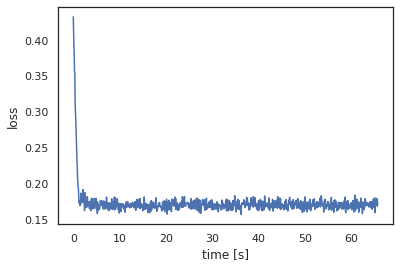

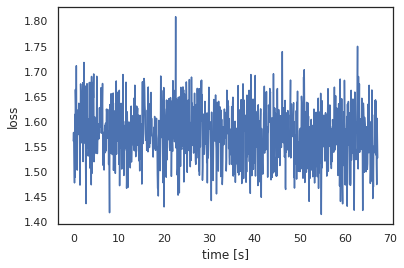

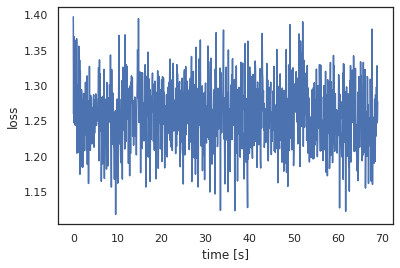

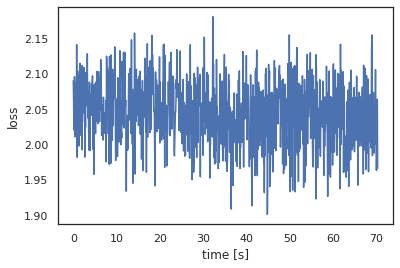

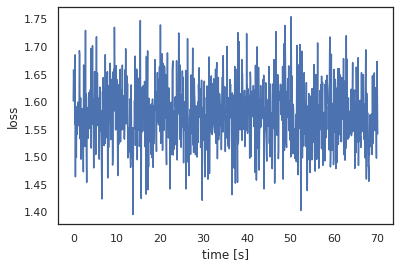

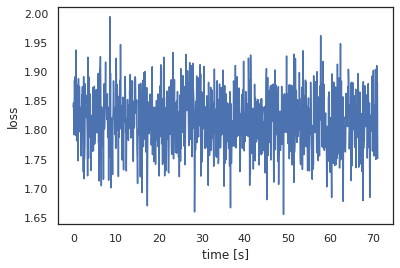

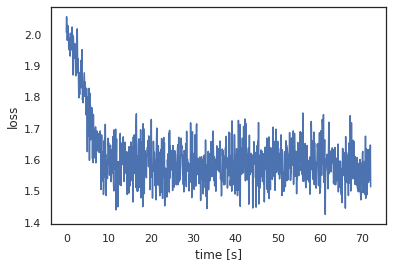

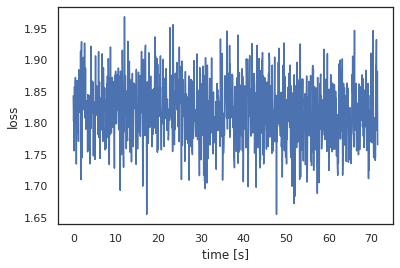

In [30]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [31]:
flips, a_R, loss

((1, 1, 1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([0.17098438, 0.01317988, 0.22689199])>],
 0.17521755508496734)

In [32]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [33]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.12973866189875452
Geodesic distance:  0.12994516828095914  rad ( 7.445309710616214  degrees)
Quaternion distance:  0.17043514391360612


(0.12973866189875452, 0.12994516828095914, 0.17043514391360612)

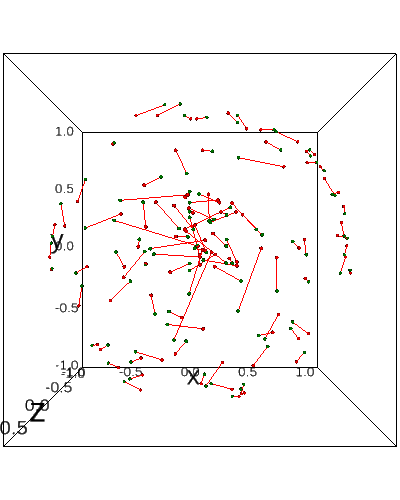

In [34]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [35]:
filename = f"figures/{PROTEIN}_after_alignment_var0.8"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

---

## 2. Asymmetric Protein (5J0N)

Data used:
- Protein: 5j0n (asymmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

### 2.1. Experiments Summary - Losses w.r.t. Different Variance Values

Different variances are added to true values of `d_Q` distance. Performace of optimizations can be seen in the plots bellow:

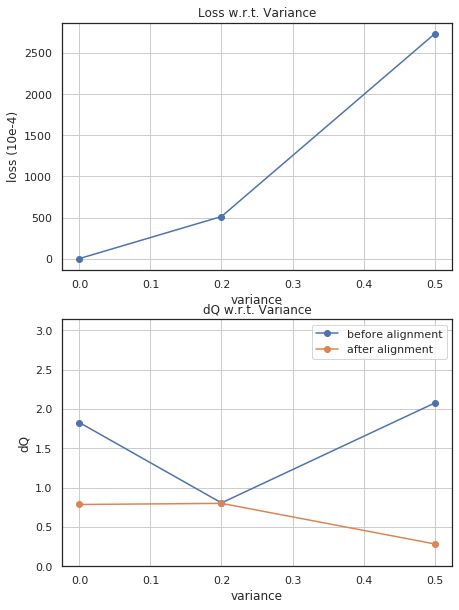

In [3]:
# losses
variances = [0.0, 0.2, 0.5]
losses = np.array([3.96e-04, 5.14e-02, 2.73e-01])
scale_degree = 4
losses = losses * 10**scale_degree

# d_Q before alignment
d_Q_before = np.array([1.827, 0.806, 2.075])

# d_Q after alignment
d_Q_after = np.array([0.786, 0.800, 0.285])


fig, ax = plt.subplots(2, 1, figsize=(7,10))
ax[0].plot(variances, losses, marker="o")
ax[0].set(xlabel='variance', ylabel=f'loss (10e{-scale_degree})', title='Loss w.r.t. Variance')
ax[0].grid()
ax[1].plot(variances, d_Q_before, marker="o", label='before alignment')
ax[1].set(xlabel='variance', ylabel='dQ', title='dQ w.r.t. Variance')
ax[1].plot(variances, d_Q_after, marker="o", label='after alignment')
ax[1].set_ylim((0, np.pi))
ax[1].grid()
ax[1].legend()

#fig.savefig("test.png")
plt.show()

---

### 2.2. Data Preparation

In [20]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [21]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


#### Projections

In [22]:
projections = data['Projections']

#### True Angles

In [23]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

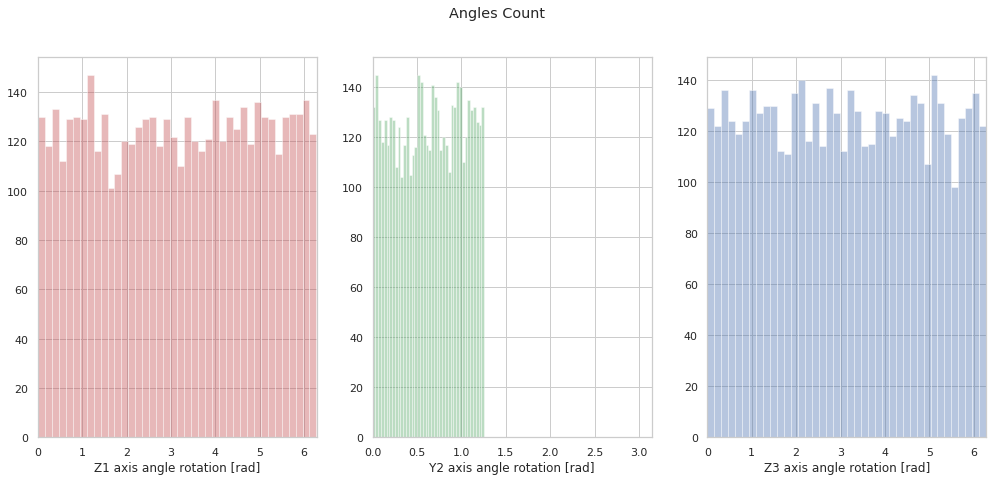

In [7]:
plot_angles_count(angles_true)

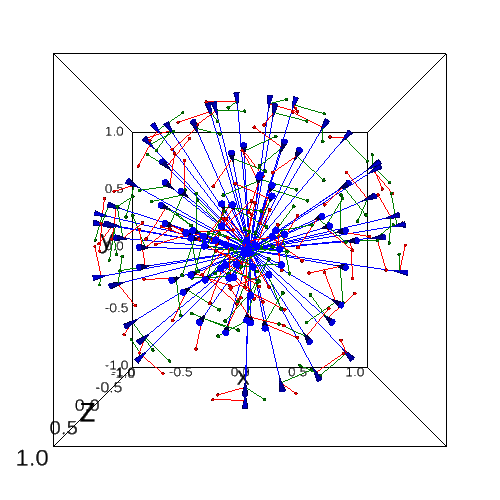

In [8]:
plot_rays(angles_true, indices=range(100))

In [9]:
display(ipv.screenshot())

Output()

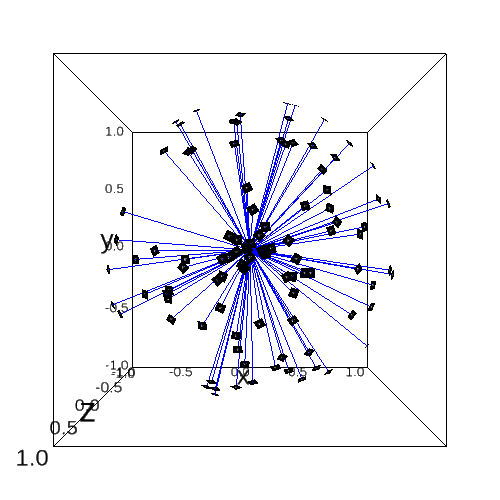

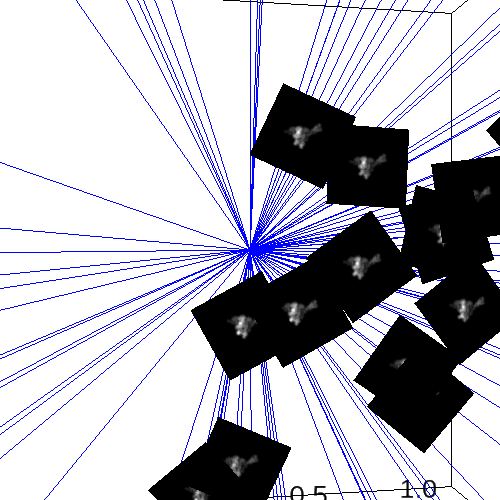

In [22]:
plot_images(angles_true, projections, indices=range(100), img_size_scale=0.05)

In [24]:
display(ipv.screenshot())

Output()

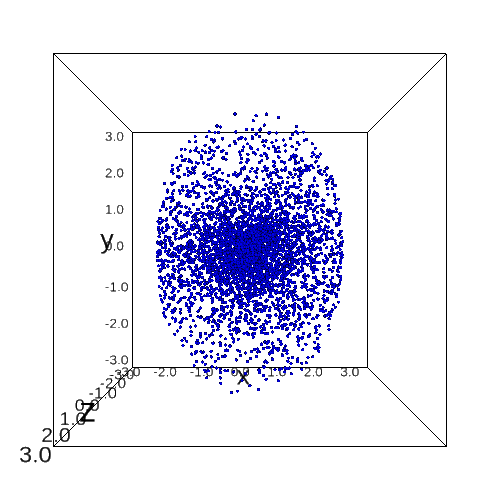

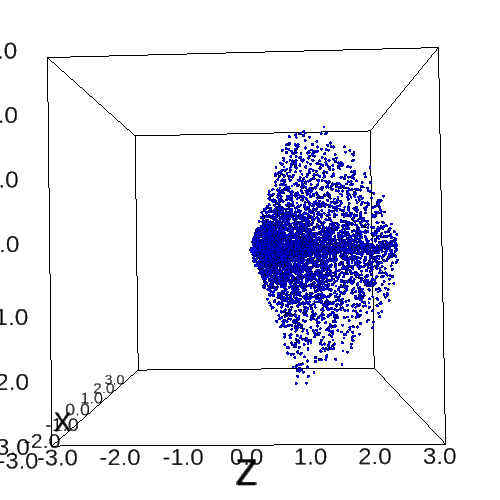

In [25]:
plot_angles_with_3rd_angle_magnitude(angles_true)

In [27]:
display(ipv.screenshot())

Output()

#### Predicted Angles

In [24]:
angle_shift = [0.0, 0.0, 0.0]
angle_coverage = [2.0, 0.4, 2.0]

In [25]:
low_ang = [x*np.pi for x in angle_shift]
high_ang = [x*np.pi for x in angle_coverage]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(angles_true), 3))

angles_predicted = [tf.Variable(e) for e in euler]


angles_predicted = np.array(angles_predicted)
angles_predicted.shape

(5000,)

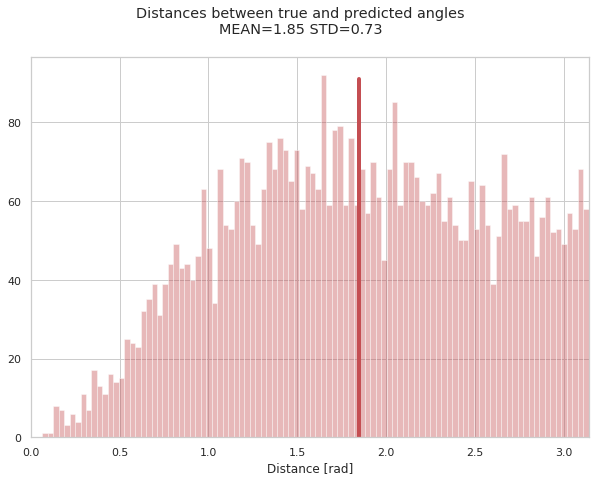

In [26]:
plot_distances_count(angles_predicted, angles_true)

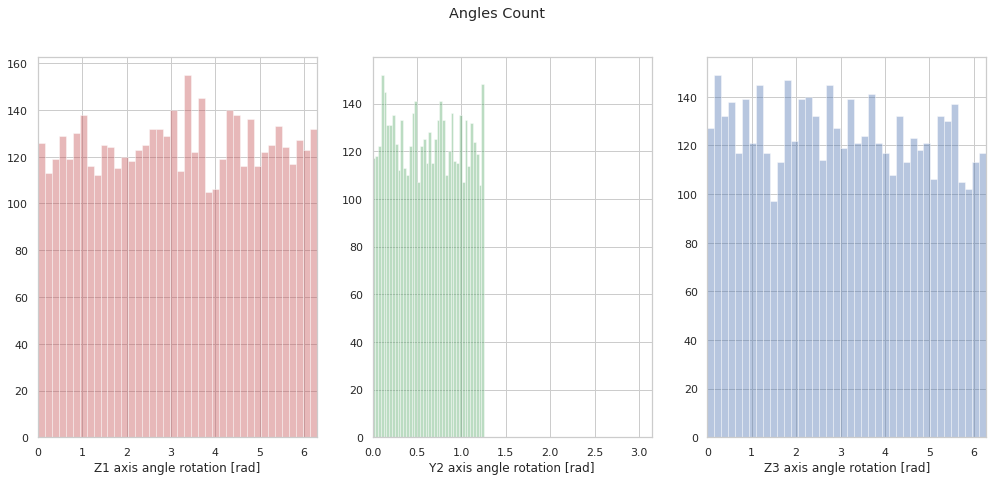

In [30]:
plot_angles_count(angles_predicted)

In [31]:
plot_euclidean_space(angles_predicted)

In [32]:
plot_euclidean_space(angles_true)

---

### 2.3. Angle Recovery: Perfect Distance

#### dP/dQ plot

In [10]:
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [11]:
def d_p(in1, in2):
    return d_q(in1, in2)

In [12]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

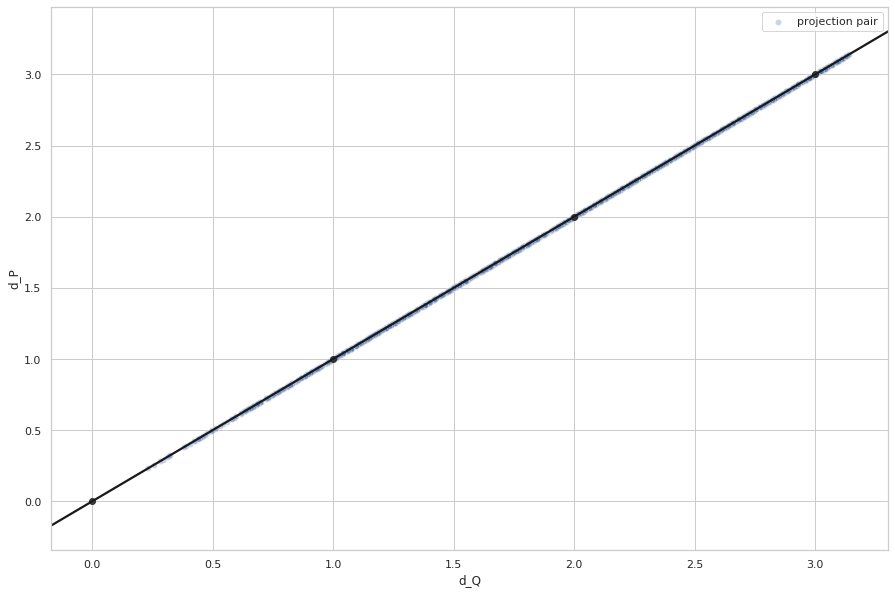

In [13]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

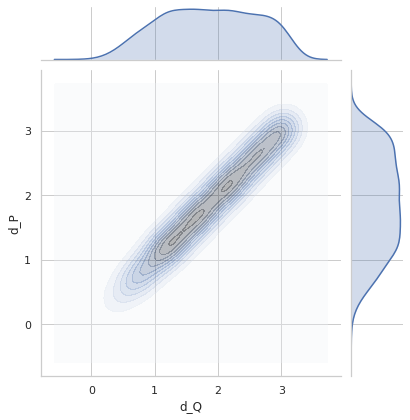

In [14]:
plot_dP_dQ_density(dP_values, dQ_values)

#### Angle Recovery

Perfect distances. Learning rate 0.01

In [15]:
from cryoem.angle_recovery import train_angle_recovery

step 15000/150000 (1833s): loss = 9.39e-02
step 30000/150000 (3621s): loss = 8.31e-02
step 45000/150000 (5454s): loss = 2.48e-02
step 60000/150000 (7256s): loss = 1.80e-03
step 75000/150000 (9061s): loss = 5.00e-04
step 90000/150000 (10850s): loss = 3.72e-04
step 105000/150000 (12638s): loss = 4.74e-04
step 120000/150000 (14524s): loss = 4.60e-04
step 135000/150000 (16384s): loss = 5.14e-04
step 150000/150000 (18282s): loss = 3.96e-04


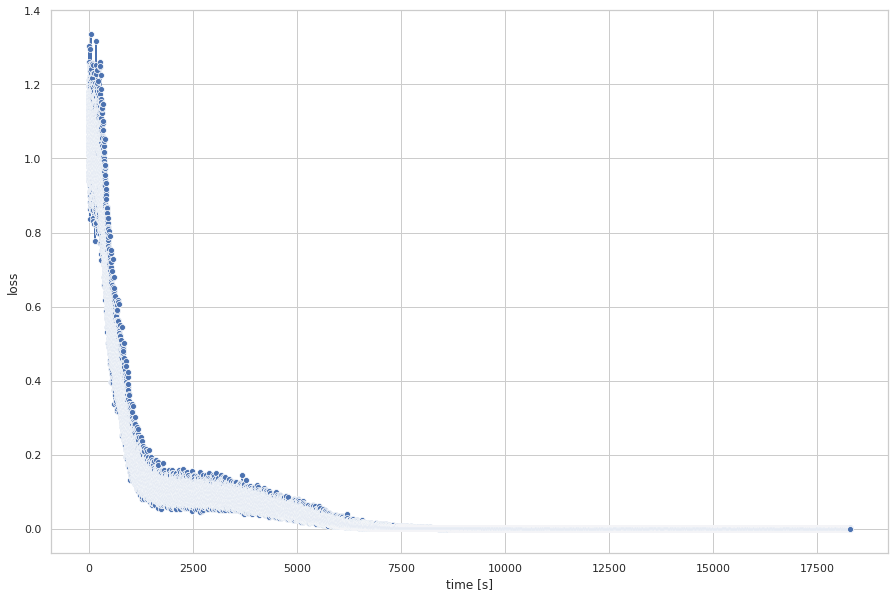

In [16]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [19]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("5j0n_predicted_angles.npy", ang_save)

In [20]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("5j0n_predicted_angles.npy")

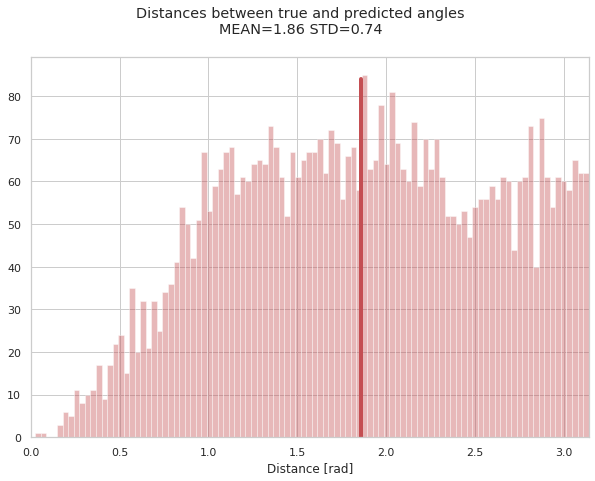

In [27]:
plot_distances_count(ap, angles_true)

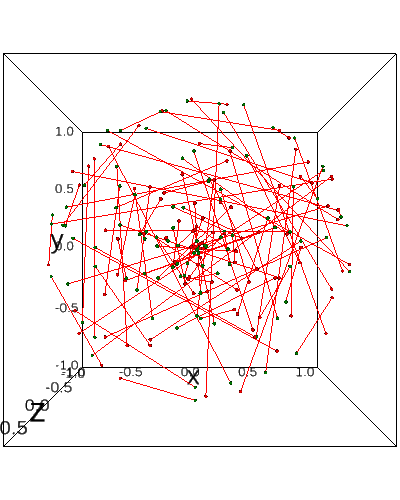

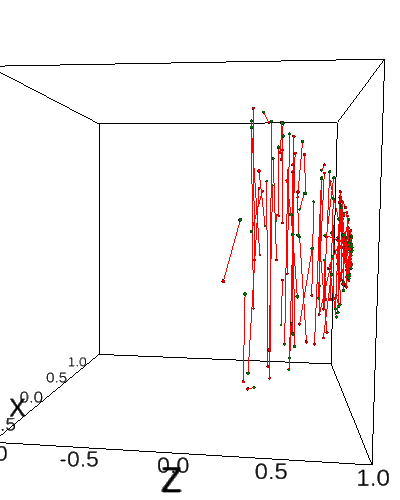

In [21]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [23]:
display(ipv.screenshot())

Output()

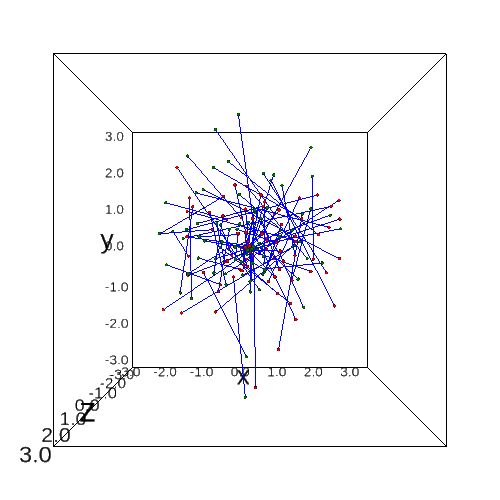

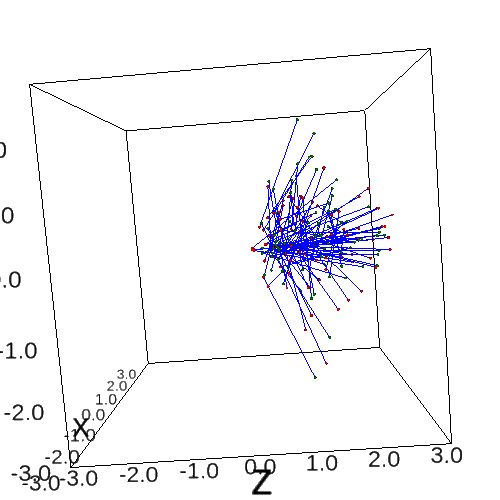

In [24]:
plot_selected_angles_with_3rd_angle_magnitude(ap, angles_true, range(100))

In [26]:
display(ipv.screenshot())

Output()

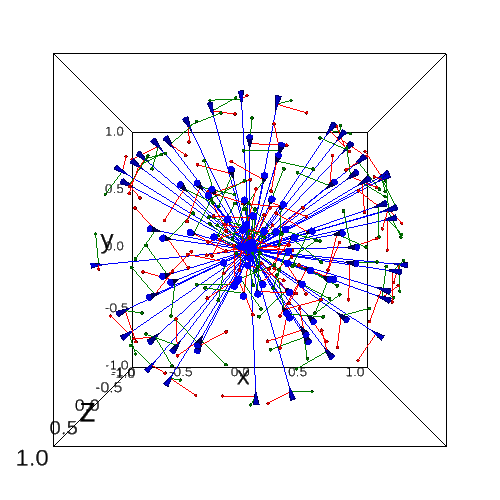

In [27]:
plot_rays(ap, indices=range(100))

In [28]:
display(ipv.screenshot())

Output()

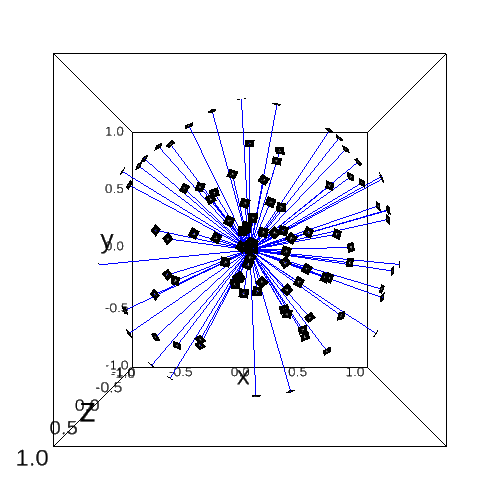

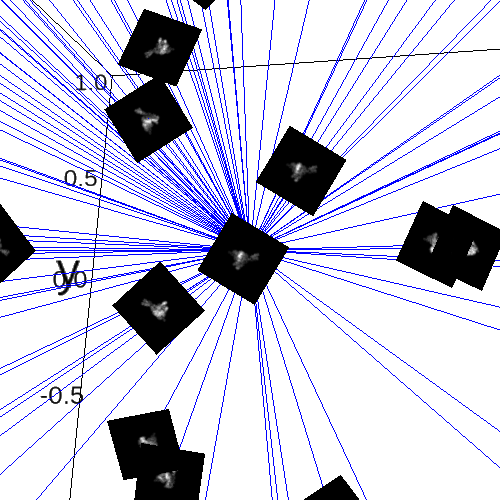

In [29]:
plot_images(ap, projections, indices=range(100),img_size_scale=0.05)

In [31]:
display(ipv.screenshot())

Output()

#### Angles' Alignment

In [37]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, updateR_alignment

#### Quaternion Alignment

In [38]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7128134720322381
Geodesic distance:  0.7740014290010898  rad ( 44.34701521885708  degrees)
Quaternion distance:  1.8270133311219365


(0.7128134720322381, 0.7740014290010898, 1.8270133311219365)

FLIPPING: (1, 1, 1)
step 100/1000 (10s): loss = 1.83e+00
step 200/1000 (19s): loss = 1.92e+00
step 300/1000 (29s): loss = 1.76e+00
step 400/1000 (38s): loss = 1.82e+00
step 500/1000 (48s): loss = 1.80e+00
step 600/1000 (57s): loss = 1.72e+00
step 700/1000 (67s): loss = 1.84e+00
step 800/1000 (76s): loss = 1.75e+00
step 900/1000 (86s): loss = 1.76e+00
step 1000/1000 (96s): loss = 1.85e+00
Rotation: [-0.85426502 -0.00420539 -0.87452053];  Loss: 1.8539374676213487
FLIPPING: (1, 1, -1)
step 100/1000 (10s): loss = 1.80e+00
step 200/1000 (19s): loss = 1.82e+00
step 300/1000 (30s): loss = 1.88e+00
step 400/1000 (39s): loss = 1.80e+00
step 500/1000 (49s): loss = 1.85e+00
step 600/1000 (58s): loss = 1.75e+00
step 700/1000 (68s): loss = 1.83e+00
step 800/1000 (77s): loss = 1.76e+00
step 900/1000 (87s): loss = 1.86e+00
step 1000/1000 (97s): loss = 1.87e+00
Rotation: [ 0.22006837 -0.00704033  0.23911573];  Loss: 1.867599111990661
FLIPPING: (1, -1, 1)
step 100/1000 (10s): loss = 1.86e+00
step 200/1

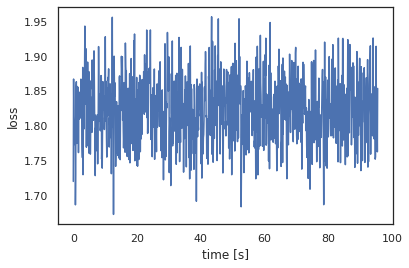

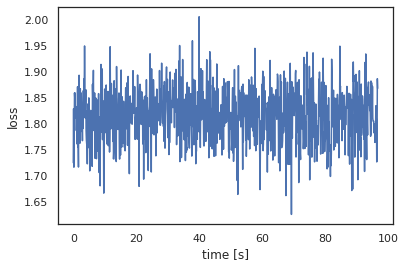

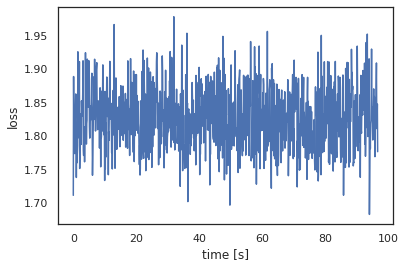

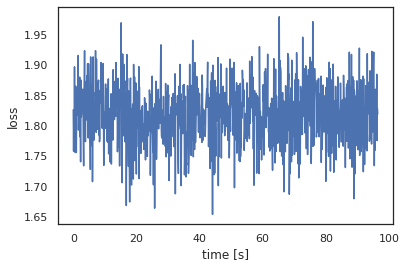

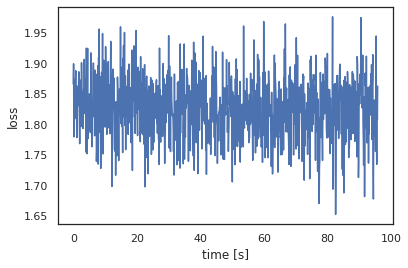

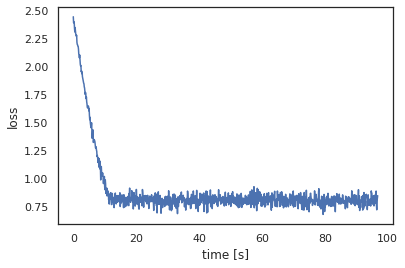

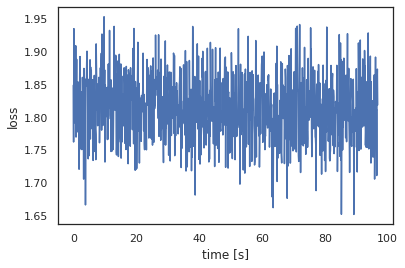

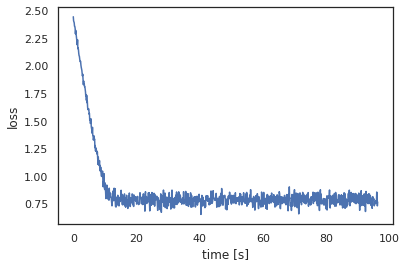

In [39]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [40]:
flips, a_R, loss

((-1, -1, -1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([-1.17304862,  0.00356662, -1.17243231])>],
 0.7665804240592266)

In [41]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [42]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.6937805937542387
Geodesic distance:  0.7520183462892541  rad ( 43.087477358781896  degrees)
Quaternion distance:  0.7863202591820717


(0.6937805937542387, 0.7520183462892541, 0.7863202591820717)

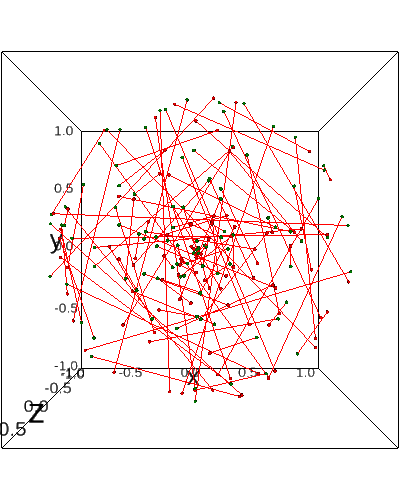

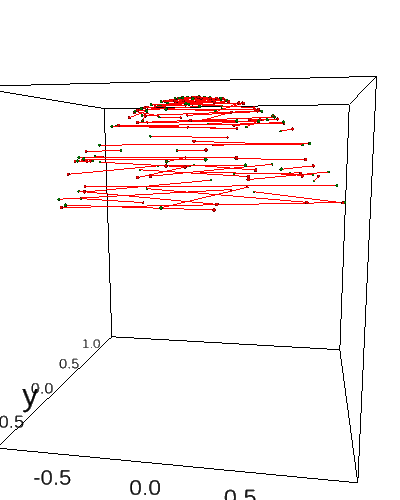

In [43]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [45]:
display(ipv.screenshot())

Output()

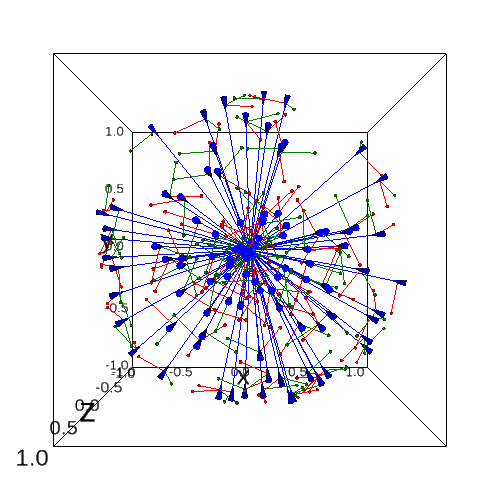

In [46]:
plot_rays(angles_predicted_new, range(100))

In [47]:
display(ipv.screenshot())

Output()

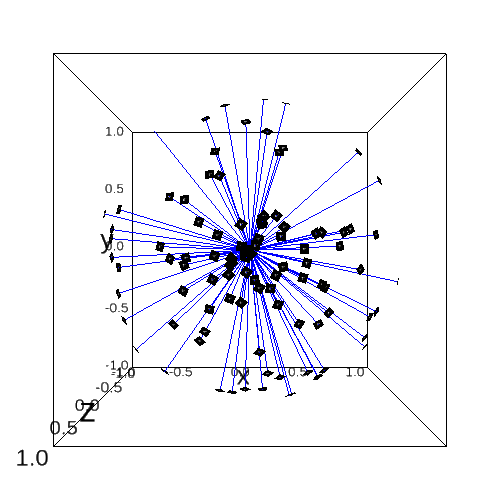

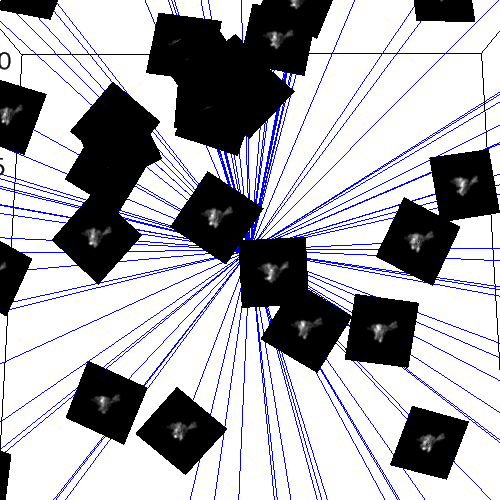

In [48]:
plot_images(angles_predicted_new, projections, indices=range(100),img_size_scale=0.05)

In [50]:
display(ipv.screenshot())

Output()

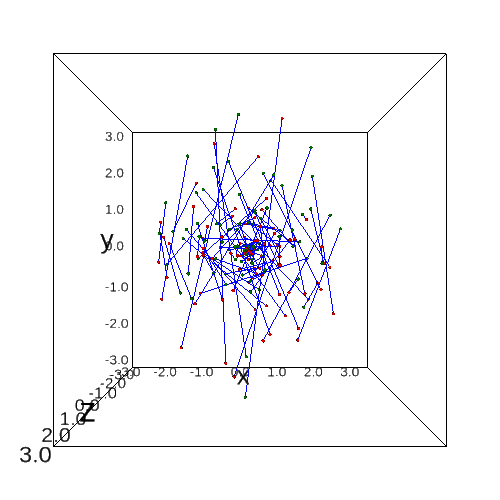

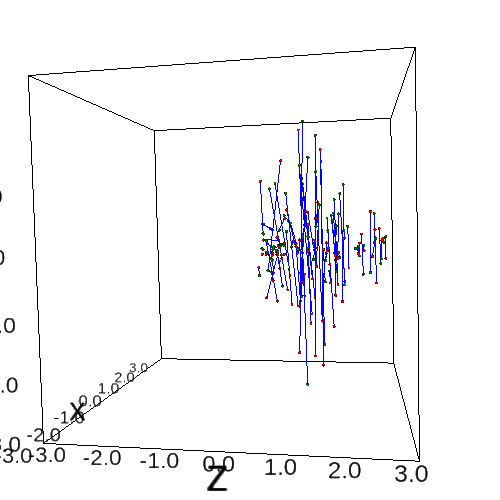

In [51]:
plot_selected_angles_with_3rd_angle_magnitude(angles_predicted_new, angles_true, range(100))

In [53]:
display(ipv.screenshot())

Output()

---

### 2.4. Angle Recovery: Variance 0.0

#### dP/dQ plot

In [13]:
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [14]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.0, dtype=tf.float64)
    return norm_distr  

In [15]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)#.T[0]
dQ_values = d_q(q1_true, q2_true)#.numpy()

<Figure size 432x288 with 0 Axes>

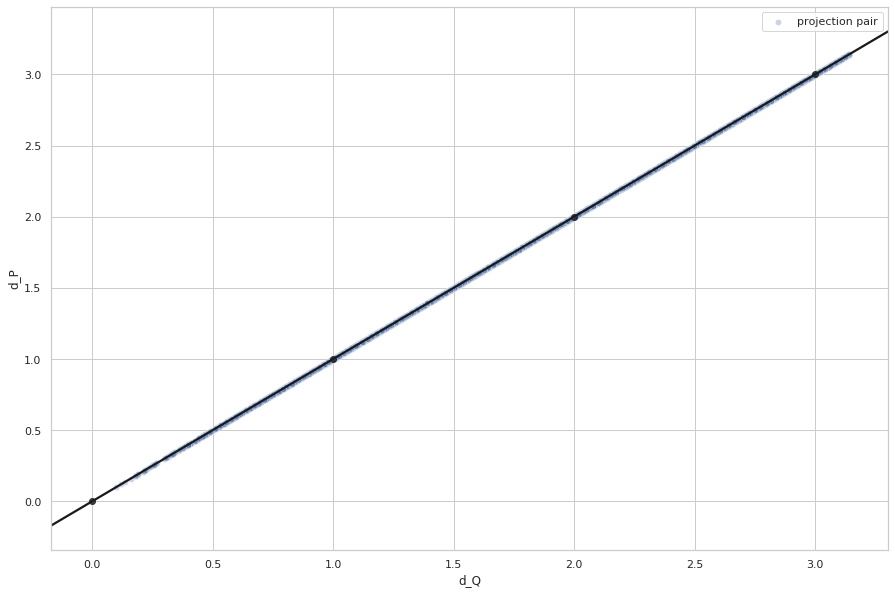

In [16]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

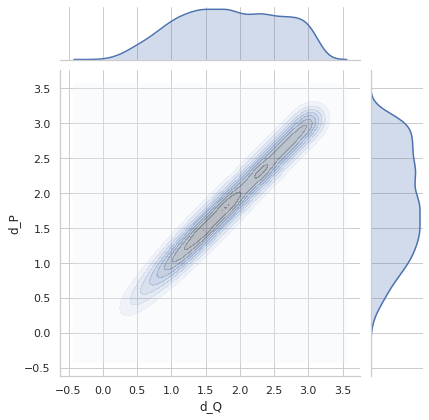

In [17]:
plot_dP_dQ_density(dP_values, dQ_values)

## Angle Recovery

Perfect distances. Learning rate 0.01

In [18]:
from cryoem.angle_recovery import train_angle_recovery

In [ ]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

step 15000/150000 (1951s): loss = 9.32e-02
step 30000/150000 (3819s): loss = 9.04e-02
step 45000/150000 (5648s): loss = 5.19e-02
step 60000/150000 (7496s): loss = 3.52e-02
step 75000/150000 (9361s): loss = 4.28e-03
step 90000/150000 (11172s): loss = 6.86e-04
step 105000/150000 (13033s): loss = 3.99e-04


In [ ]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/5j0n_predicted_angles_var0.npy", ang_save)

In [29]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/5j0n_predicted_angles_var0.npy")

In [ ]:
plot_distances_count(ap, angles_true)

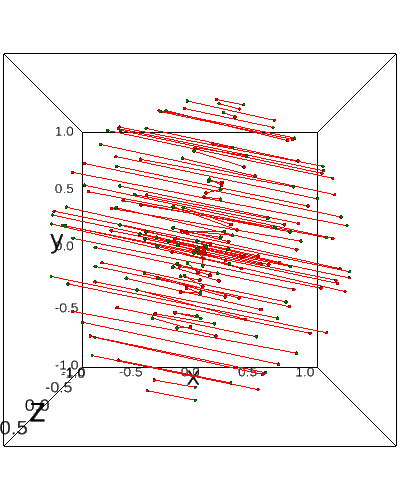

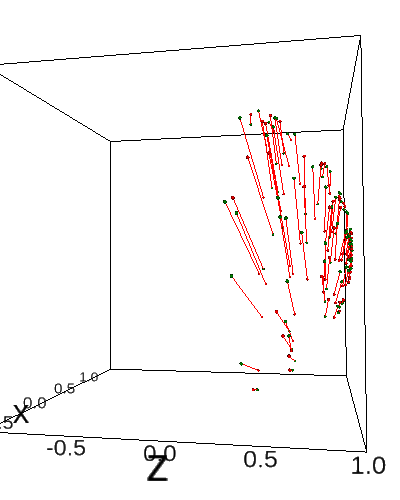

In [20]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [22]:
display(ipv.screenshot())

Output()

### Angle Alignment

In [24]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, updateR_alignment

#### Quaternion Alignment

In [25]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7126255098249455
Geodesic distance:  0.7738962755045573  rad ( 44.34099036730473  degrees)
Quaternion distance:  1.804002719050027


(0.7126255098249455, 0.7738962755045573, 1.804002719050027)

FLIPPING: (1, 1, 1)
step 500/5000 (47s): loss = 1.81e+00
step 1000/5000 (94s): loss = 1.82e+00
step 1500/5000 (140s): loss = 1.79e+00
step 2000/5000 (187s): loss = 1.82e+00
step 2500/5000 (234s): loss = 1.74e+00
step 3000/5000 (281s): loss = 1.85e+00
step 3500/5000 (327s): loss = 1.78e+00
step 4000/5000 (374s): loss = 1.77e+00
step 4500/5000 (420s): loss = 1.80e+00
step 5000/5000 (467s): loss = 1.86e+00
Rotation: [5.65906161e-01 1.38507948e-05 5.71285007e-01];  Loss: 1.860901035947026
FLIPPING: (1, 1, -1)
step 500/5000 (47s): loss = 1.60e+00
step 1000/5000 (93s): loss = 1.54e+00
step 1500/5000 (141s): loss = 1.61e+00
step 2000/5000 (188s): loss = 1.57e+00
step 2500/5000 (234s): loss = 1.52e+00
step 3000/5000 (281s): loss = 1.59e+00
step 3500/5000 (329s): loss = 1.53e+00
step 4000/5000 (376s): loss = 1.48e+00
step 4500/5000 (422s): loss = 1.54e+00
step 5000/5000 (470s): loss = 1.66e+00
Rotation: [-1.37570889 -0.00482575 -1.34775901];  Loss: 1.6630476512434507
FLIPPING: (1, -1, 1)
step 5

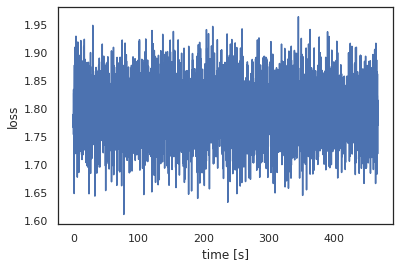

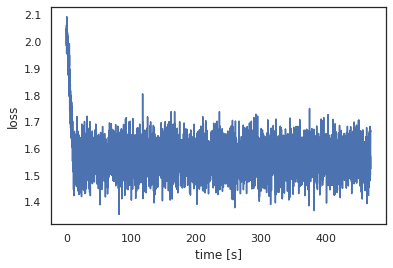

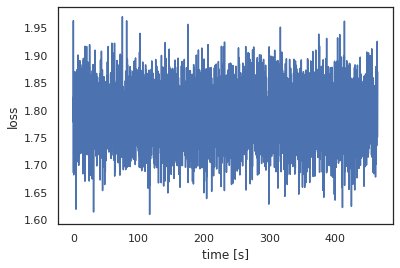

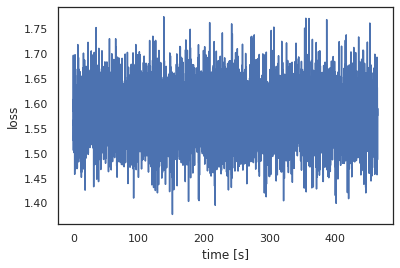

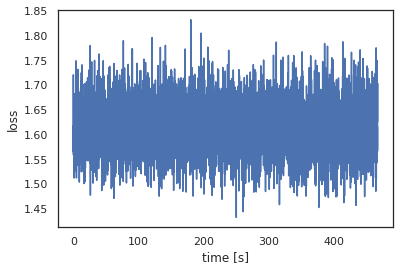

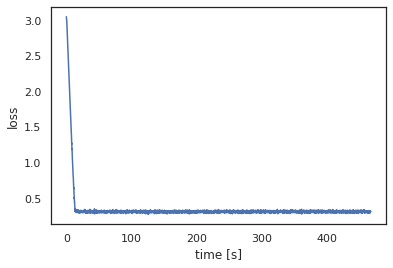

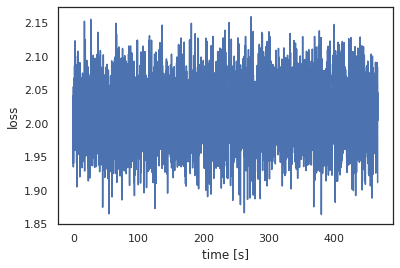

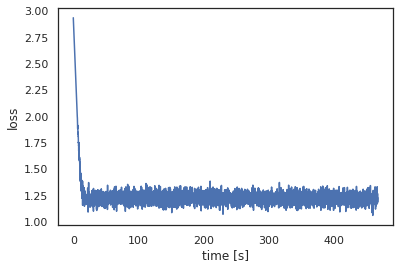

In [26]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=5000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [27]:
flips, a_R, loss

((-1, 1, -1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([1.50157382, 0.02016914, 1.58842314])>],
 0.31754020187752174)

In [28]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [29]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.2530815542505399
Geodesic distance:  0.254271104790386  rad ( 14.568661156617807  degrees)
Quaternion distance:  0.3125839033835222


(0.2530815542505399, 0.254271104790386, 0.3125839033835222)

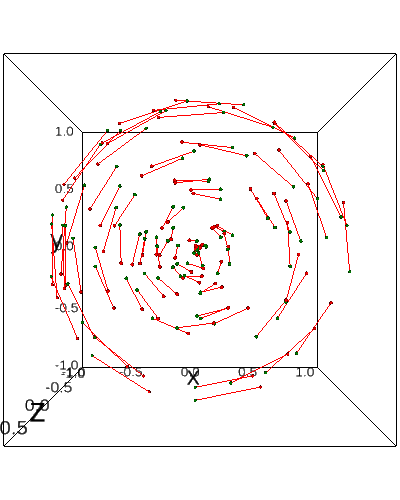

In [30]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [31]:
display(ipv.screenshot())

Output()

---

### 2.5. Angle Recovery: Variance 0.2

#### dP/dQ plot

In [9]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.2, dtype=tf.float64)
    return norm_distr  

In [10]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

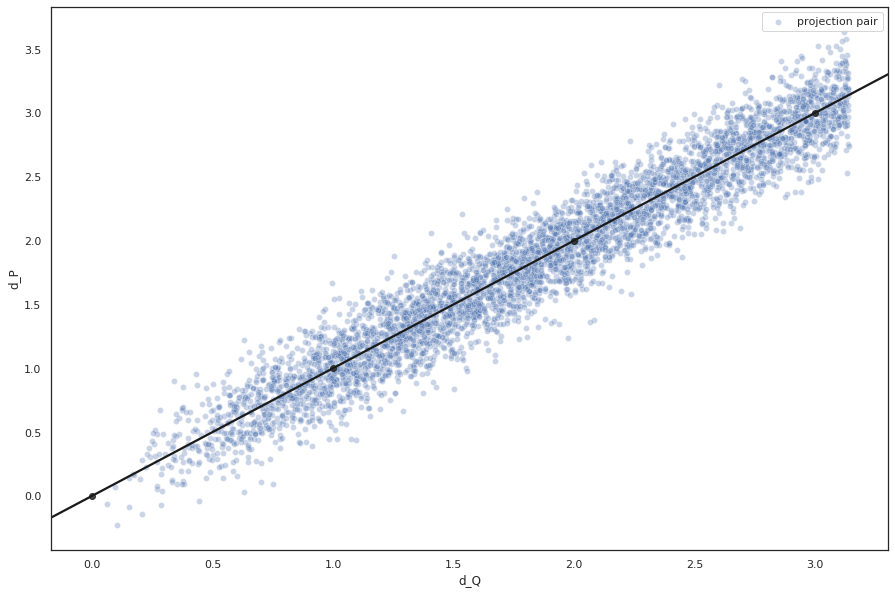

In [11]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

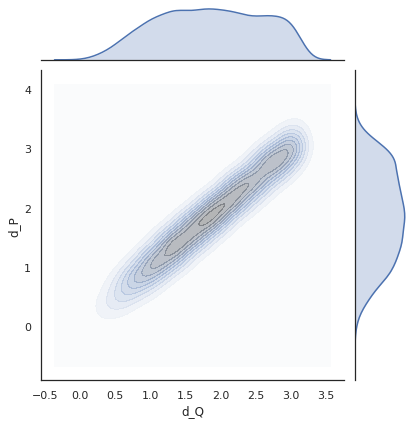

In [12]:
plot_dP_dQ_density(dP_values, dQ_values)

In [13]:
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.20069358422911474

#### Angle Recovery

In [16]:
# Try smaller variance until it is possible to converge

step 15000/150000 (1900s): loss = 1.15e-01
step 30000/150000 (3690s): loss = 1.14e-01
step 45000/150000 (5592s): loss = 5.95e-02
step 60000/150000 (7429s): loss = 4.56e-02
step 75000/150000 (9313s): loss = 4.66e-02
step 90000/150000 (11124s): loss = 4.63e-02
step 105000/150000 (12911s): loss = 4.67e-02
step 120000/150000 (14726s): loss = 4.31e-02
step 135000/150000 (16566s): loss = 4.21e-02
step 150000/150000 (18395s): loss = 5.14e-02


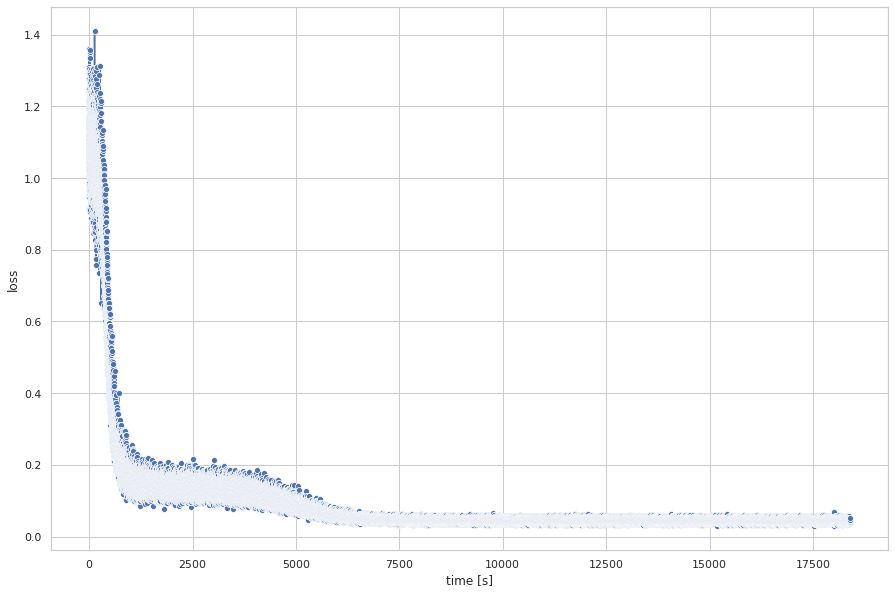

In [17]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [18]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/5j0n_predicted_angles_var0.2.npy", ang_save)

In [47]:
ap = np.load("data/5j0n_predicted_angles_var0.2.npy")

In [11]:
plot_euclidean_space(ap)

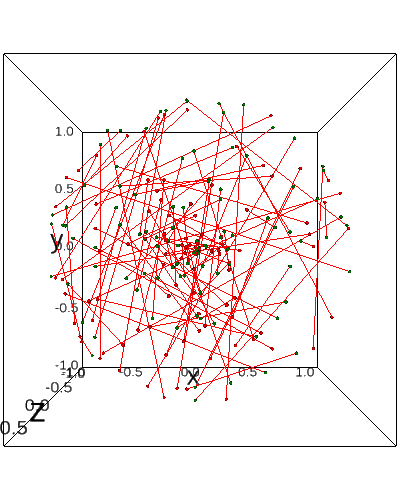

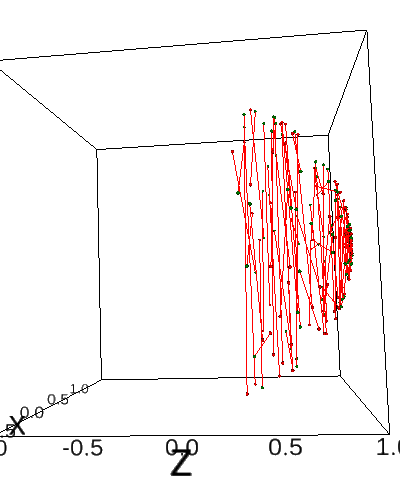

In [12]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [14]:
display(ipv.screenshot())

Output()

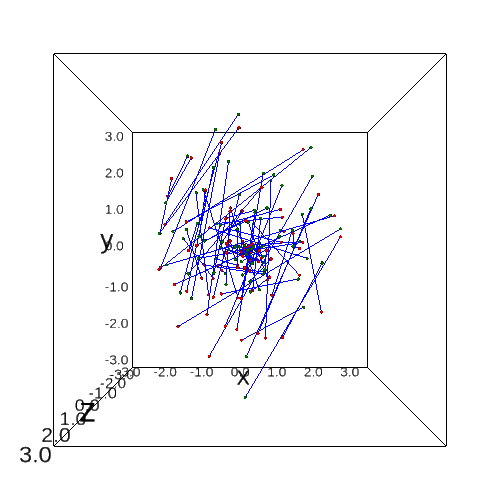

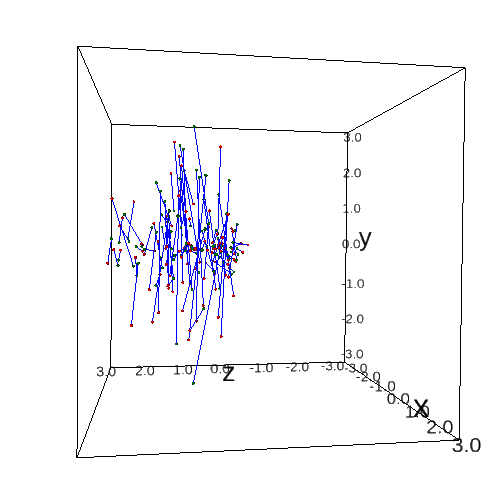

In [17]:
plot_selected_angles_with_3rd_angle_magnitude(ap, angles_true, range(100))

In [19]:
display(ipv.screenshot())

Output()

#### Angles' Alignment

In [15]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, updateR_alignment

#### Quaternion Alignment

In [16]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7039827178594478
Geodesic distance:  0.7632859162415673  rad ( 43.73306156241786  degrees)
Quaternion distance:  0.8065012186478349


(0.7039827178594478, 0.7632859162415673, 0.8065012186478349)

FLIPPING: (1, 1, 1)
step 100/1000 (9s): loss = 7.29e-01
step 200/1000 (19s): loss = 7.96e-01
step 300/1000 (28s): loss = 7.81e-01
step 400/1000 (38s): loss = 8.20e-01
step 500/1000 (47s): loss = 7.86e-01
step 600/1000 (56s): loss = 8.43e-01
step 700/1000 (66s): loss = 8.01e-01
step 800/1000 (75s): loss = 7.75e-01
step 900/1000 (85s): loss = 7.47e-01
step 1000/1000 (94s): loss = 8.16e-01
Rotation: [-0.03496581  0.00395882 -0.0277902 ];  Loss: 0.8162119941909995
FLIPPING: (1, 1, -1)
step 100/1000 (10s): loss = 1.87e+00
step 200/1000 (20s): loss = 1.82e+00
step 300/1000 (30s): loss = 1.73e+00
step 400/1000 (40s): loss = 1.76e+00
step 500/1000 (50s): loss = 1.82e+00
step 600/1000 (60s): loss = 1.91e+00
step 700/1000 (69s): loss = 1.80e+00
step 800/1000 (78s): loss = 1.78e+00
step 900/1000 (88s): loss = 1.81e+00
step 1000/1000 (97s): loss = 1.81e+00
Rotation: [-1.37299657  0.05917804 -1.35007814];  Loss: 1.80948920253194
FLIPPING: (1, -1, 1)
step 100/1000 (10s): loss = 8.60e-01
step 200/100

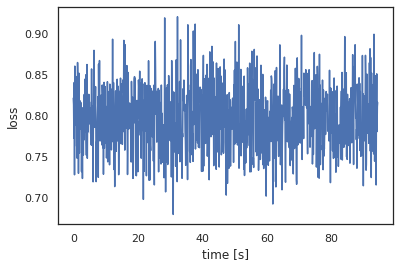

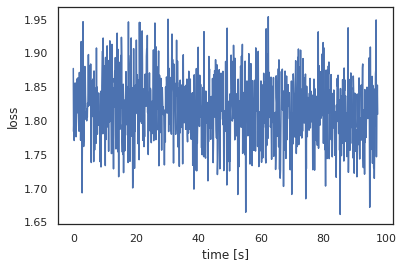

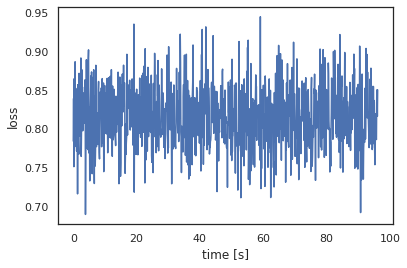

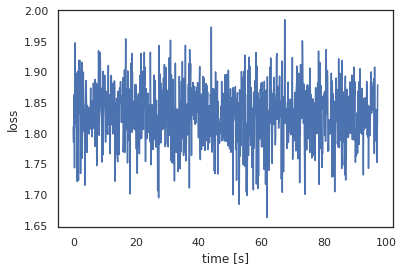

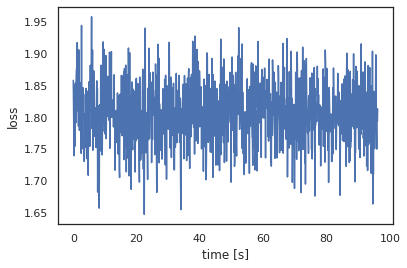

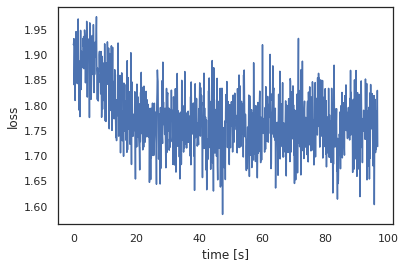

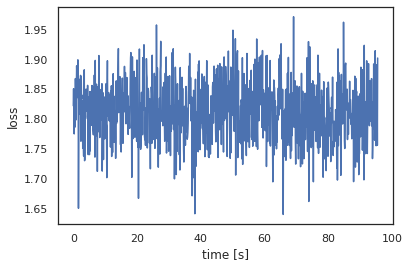

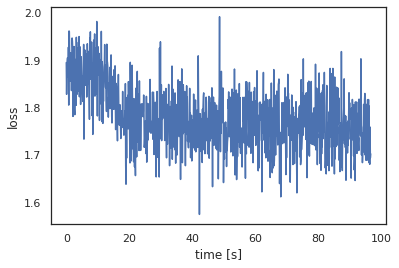

In [17]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [18]:
flips, a_R, loss

((1, 1, 1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([-0.03496581,  0.00395882, -0.0277902 ])>],
 0.8162119941909995)

In [19]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [20]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.7031941968315075
Geodesic distance:  0.7624277205887539  rad ( 43.68389057351518  degrees)
Quaternion distance:  0.8001937093120989


(0.7031941968315075, 0.7624277205887539, 0.8001937093120989)

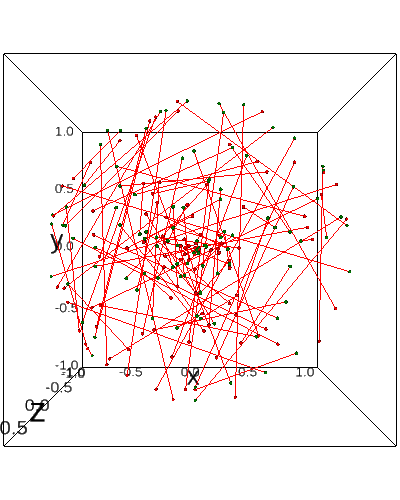

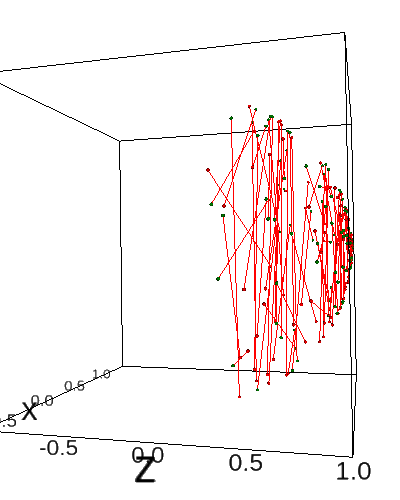

In [21]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [23]:
display(ipv.screenshot())

Output()

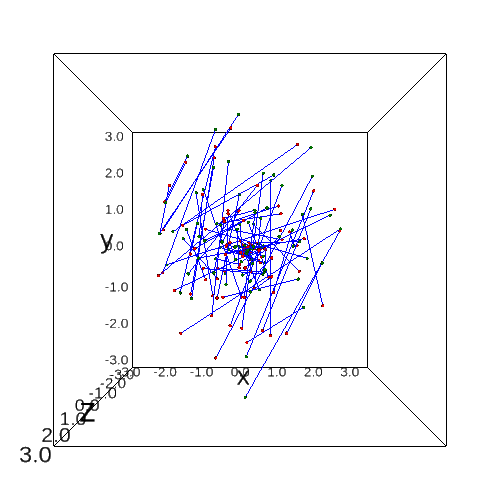

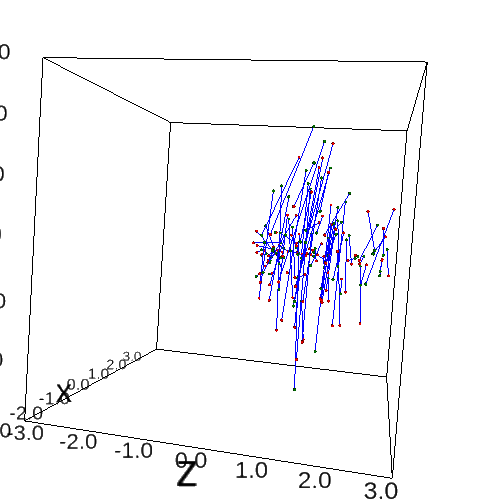

In [24]:
plot_selected_angles_with_3rd_angle_magnitude(angles_predicted_new, angles_true, range(100))

In [26]:
display(ipv.screenshot())

Output()

---

### 1.6. Angle Recovery: Variance 0.5

#### dP/dQ plot

In [27]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.5, dtype=tf.float64)
    return norm_distr  

In [28]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

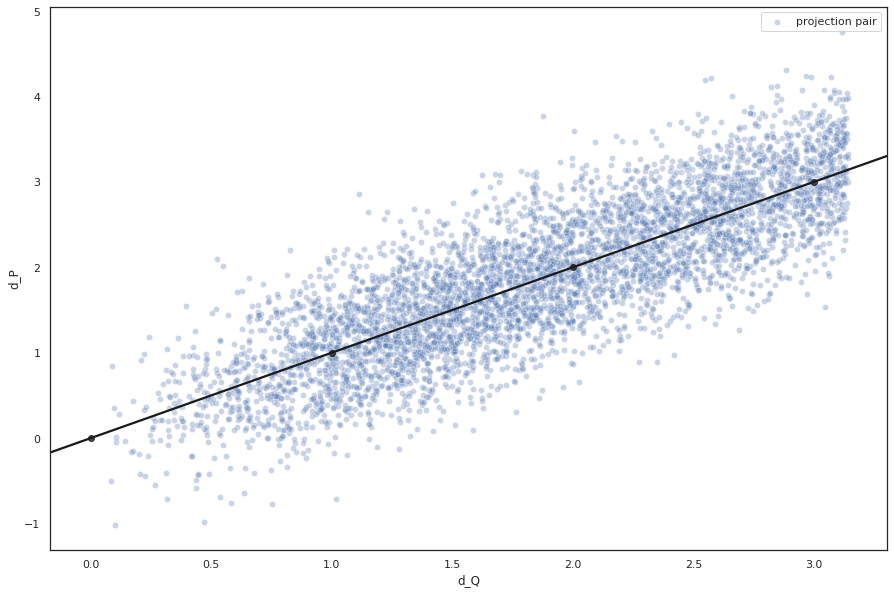

In [29]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

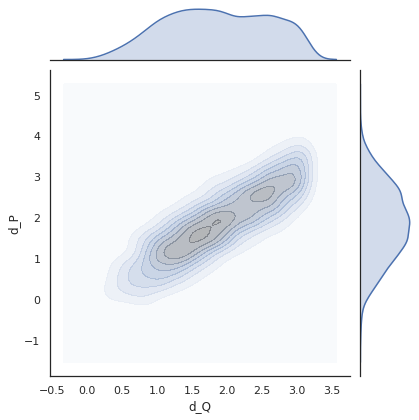

In [30]:
plot_dP_dQ_density(dP_values, dQ_values)

In [46]:
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.49672542297015565

#### Angle Recovery

In [31]:
# Try smaller variance until it is possible to converge

step 15000/150000 (1847s): loss = 3.65e-01
step 45000/150000 (5348s): loss = 4.14e-01
step 60000/150000 (7175s): loss = 3.30e-01
step 75000/150000 (8987s): loss = 3.10e-01
step 90000/150000 (10788s): loss = 2.91e-01
step 105000/150000 (12589s): loss = 3.00e-01
step 120000/150000 (14423s): loss = 2.87e-01
step 135000/150000 (16176s): loss = 2.51e-01
step 150000/150000 (17917s): loss = 2.73e-01


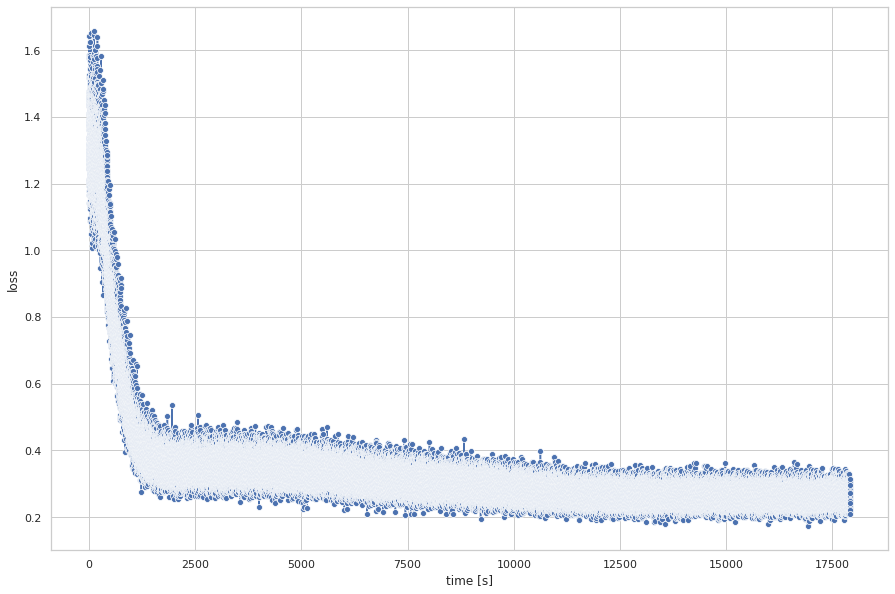

In [32]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [33]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/5j0n_predicted_angles_var0.5.npy", ang_save)

In [48]:
ap = np.load("data/5j0n_predicted_angles_var0.5.npy")

In [13]:
plot_euclidean_space(ap)

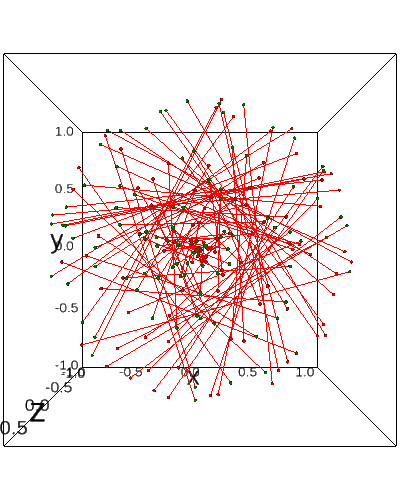

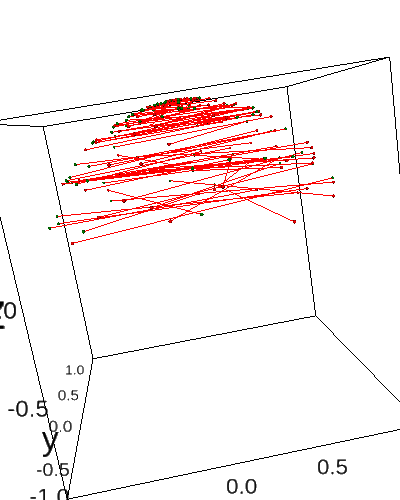

In [35]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [37]:
display(ipv.screenshot())

Output()

#### Angle Alignment

In [39]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, updateR_alignment

In [40]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  1.0177718342919242
Geodesic distance:  1.133184537632365  rad ( 64.92669141581813  degrees)
Quaternion distance:  2.075320937960786


(1.0177718342919242, 1.133184537632365, 2.075320937960786)

FLIPPING: (1, 1, 1)
step 100/1000 (10s): loss = 3.22e-01
step 200/1000 (19s): loss = 2.91e-01
step 300/1000 (29s): loss = 2.97e-01
step 400/1000 (38s): loss = 2.80e-01
step 500/1000 (48s): loss = 2.89e-01
step 600/1000 (57s): loss = 2.92e-01
step 700/1000 (67s): loss = 2.78e-01
step 800/1000 (77s): loss = 2.87e-01
step 900/1000 (86s): loss = 2.82e-01
step 1000/1000 (96s): loss = 2.77e-01
Rotation: [-1.01961593 -0.01429466 -1.01992495];  Loss: 0.27693228080045174
FLIPPING: (1, 1, -1)
step 100/1000 (10s): loss = 1.61e+00
step 200/1000 (20s): loss = 1.63e+00
step 300/1000 (29s): loss = 1.62e+00
step 400/1000 (39s): loss = 1.54e+00
step 500/1000 (48s): loss = 1.67e+00
step 600/1000 (58s): loss = 1.50e+00
step 700/1000 (67s): loss = 1.61e+00
step 800/1000 (77s): loss = 1.59e+00
step 900/1000 (86s): loss = 1.63e+00
step 1000/1000 (96s): loss = 1.69e+00
Rotation: [1.24233443 0.00987119 1.24260107];  Loss: 1.6885201429963965
FLIPPING: (1, -1, 1)
step 100/1000 (9s): loss = 1.24e+00
step 200/100

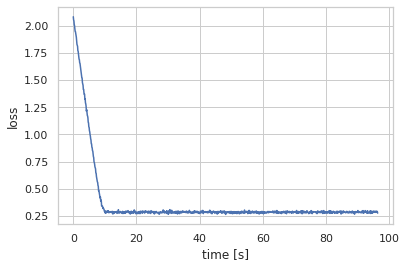

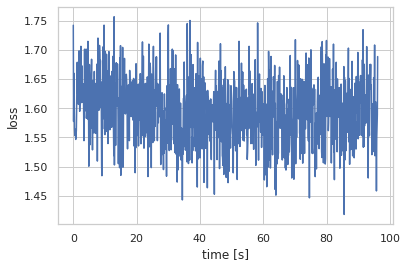

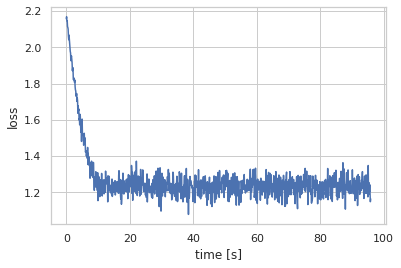

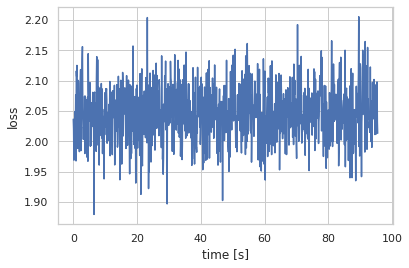

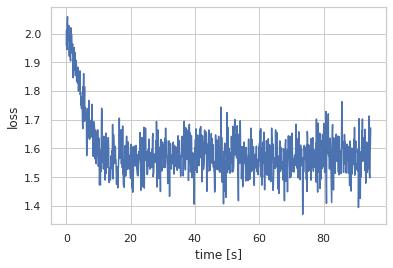

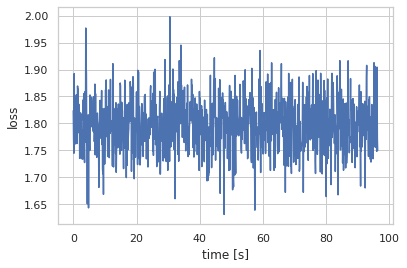

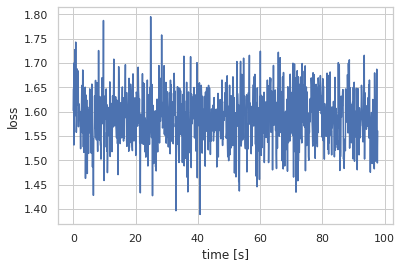

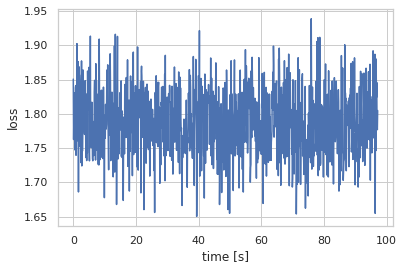

In [41]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [42]:
flips, a_R, loss

((1, 1, 1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([-1.01961593, -0.01429466, -1.01992495])>],
 0.27693228080045174)

In [43]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [44]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.21848139163955166
Geodesic distance:  0.2191668939083681  rad ( 12.557338029940965  degrees)
Quaternion distance:  0.2856773364952681


(0.21848139163955166, 0.2191668939083681, 0.2856773364952681)

In [45]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [34]:
display(ipv.screenshot())

Output()

---

### 1.7. Angle Recovery: Variance 0.8

#### dP/dQ plot

In [13]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.8, dtype=tf.float64)
    return norm_distr  

In [14]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

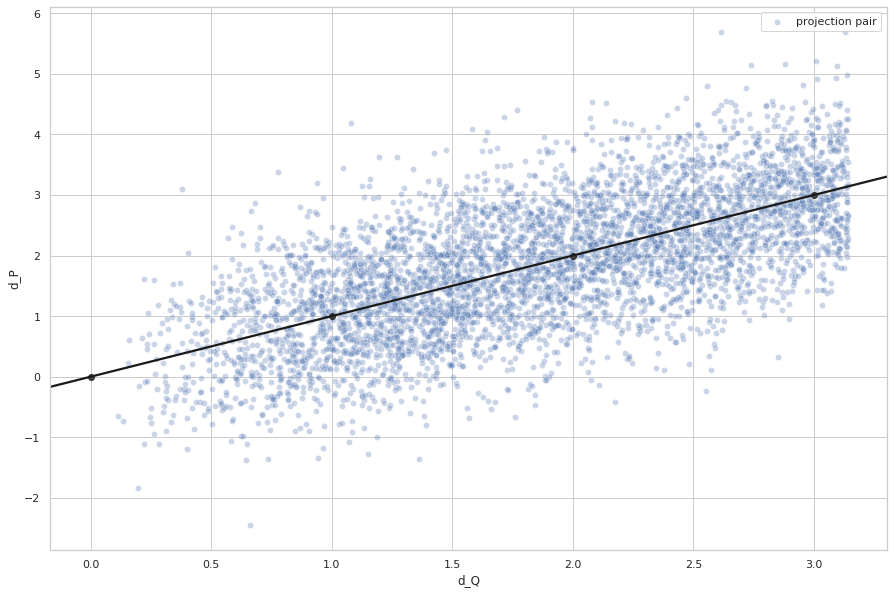

In [15]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

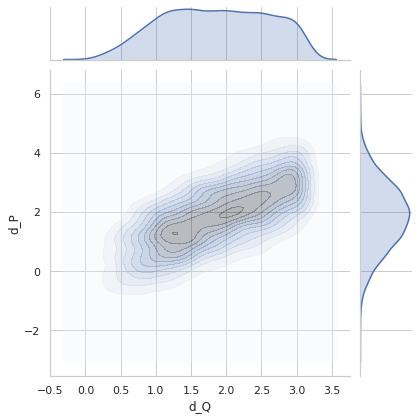

In [16]:
plot_dP_dQ_density(dP_values, dQ_values)

#### Angle Recovery

In [17]:
# Try smaller variance until it is possible to converge

step 15000/150000 (1377s): loss = 7.84e-01
step 30000/150000 (2800s): loss = 6.97e-01
step 45000/150000 (4231s): loss = 6.67e-01
step 60000/150000 (5712s): loss = 6.87e-01
step 75000/150000 (7162s): loss = 7.59e-01
step 90000/150000 (8665s): loss = 6.65e-01
step 105000/150000 (10180s): loss = 7.26e-01
step 120000/150000 (11723s): loss = 6.59e-01
step 135000/150000 (13170s): loss = 7.20e-01
step 150000/150000 (14638s): loss = 6.32e-01


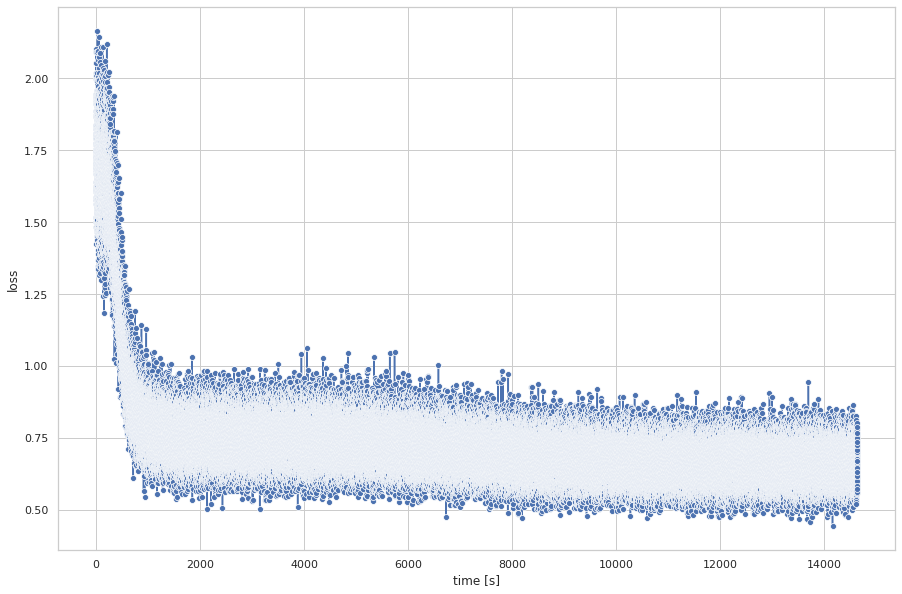

In [18]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [23]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/5j0n_predicted_angles_var0.8.npy", ang_save)

In [24]:
ap = np.load("data/5j0n_predicted_angles_var0.8.npy")

In [25]:
plot_euclidean_space(ap)

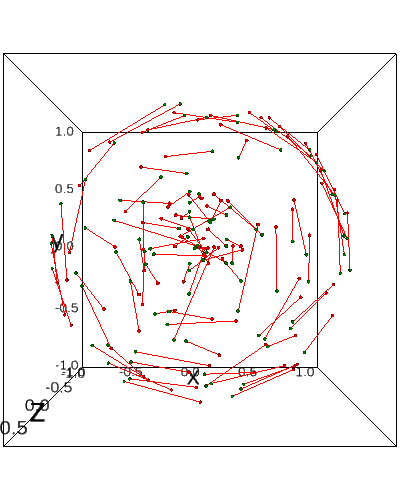

In [26]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [27]:
display(ipv.screenshot())

Output()

#### Angle Alignment

In [28]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, training_angle_alignment_GD_flips, updateR_alignment, updateGD_alignment

In [29]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.29311857540805325
Geodesic distance:  0.29482953242402793  rad ( 16.89248788371226  degrees)
Quaternion distance:  0.4303240739610892


(0.29311857540805325, 0.29482953242402793, 0.4303240739610892)

FLIPPING: (1, 1, 1)
step 100/1000 (6s): loss = 1.65e-01
step 200/1000 (13s): loss = 1.66e-01
step 300/1000 (20s): loss = 1.76e-01
step 400/1000 (26s): loss = 1.72e-01
step 500/1000 (33s): loss = 1.68e-01
step 600/1000 (40s): loss = 1.68e-01
step 700/1000 (46s): loss = 1.65e-01
step 800/1000 (53s): loss = 1.68e-01
step 900/1000 (59s): loss = 1.76e-01
step 1000/1000 (66s): loss = 1.75e-01
Rotation: [0.17098438 0.01317988 0.22689199];  Loss: 0.17521755508496734
FLIPPING: (1, 1, -1)
step 100/1000 (7s): loss = 1.53e+00
step 200/1000 (13s): loss = 1.54e+00
step 300/1000 (20s): loss = 1.63e+00
step 400/1000 (27s): loss = 1.54e+00
step 500/1000 (34s): loss = 1.57e+00
step 600/1000 (40s): loss = 1.62e+00
step 700/1000 (47s): loss = 1.54e+00
step 800/1000 (54s): loss = 1.51e+00
step 900/1000 (60s): loss = 1.43e+00
step 1000/1000 (67s): loss = 1.53e+00
Rotation: [-1.16161379 -0.00471375 -1.16927731];  Loss: 1.5271332334188548
FLIPPING: (1, -1, 1)
step 100/1000 (7s): loss = 1.29e+00
step 200/1000 

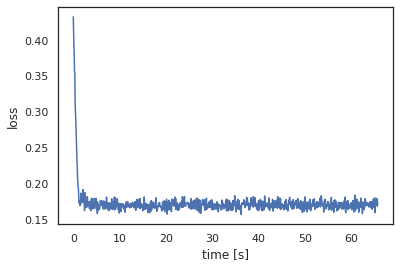

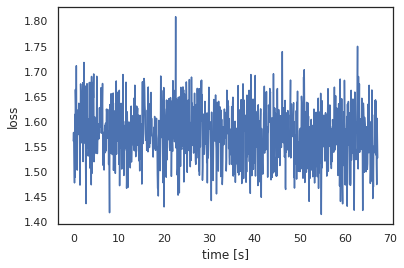

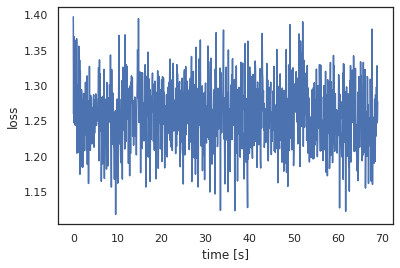

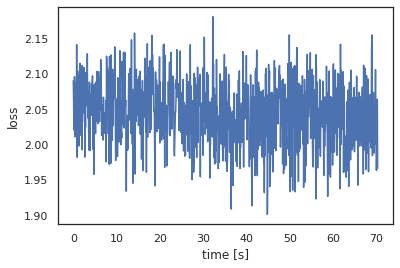

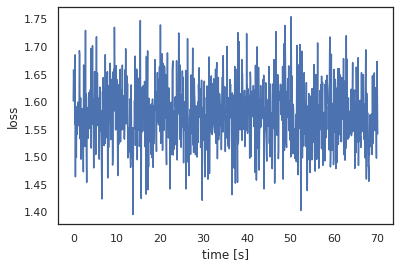

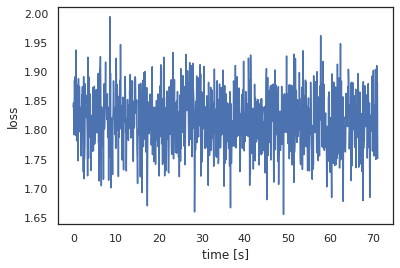

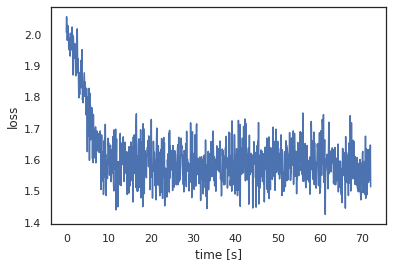

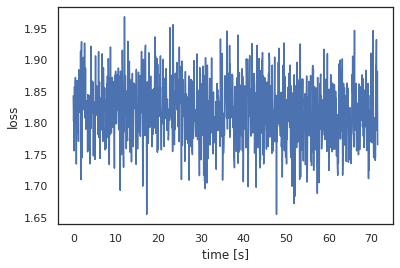

In [30]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [31]:
flips, a_R, loss

((1, 1, 1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([0.17098438, 0.01317988, 0.22689199])>],
 0.17521755508496734)

In [32]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [33]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.12973866189875452
Geodesic distance:  0.12994516828095914  rad ( 7.445309710616214  degrees)
Quaternion distance:  0.17043514391360612


(0.12973866189875452, 0.12994516828095914, 0.17043514391360612)

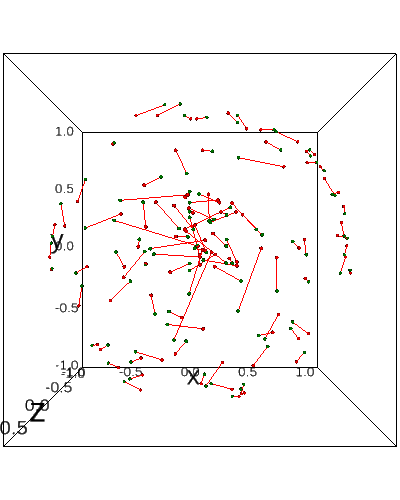

In [34]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [35]:
display(ipv.screenshot())

Output()

---

In [ ]:
# TODO: 0.0

# TODO: 0.2

# TODO: 0.5

# TODO: 0.8